In [1]:
from google.colab import files
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

In [2]:
#drive.mount('/content/drive', force_remount=True)
#uploaded = files.upload()


In [3]:
db_url = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021.csv'
df_departamentos = pd.read_csv(db_url)
df_departementos_complete = df_departamentos.copy()

db_url_train = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021.csv'
df_departamentos_train = pd.read_csv(db_url_train)
df_departementos_complete_train = df_departamentos.copy()


```
# This is formatted as code
```

# Procesamiento del Dataset  


Se crea un nuevo dataset el cual cumpla con los requisitos pedidos, los cuales son:
- El tipo de propiedad sea: Casa, Ph o Departamento
- Que se encuentre en Capital Federal
- Su precio se encuentre en dolares
- Que esté en venta

In [4]:
variable_name = ""
polygon_coords = [
    (-58.4576, -34.5265),
    (-58.5698, -34.6178),
    (-58.4609, -34.7051),
    (-58.3324, -34.6284)
]
buenos_aires_polygon = Polygon(polygon_coords)


vivienda_df = df_departementos_complete.copy()


vivienda_df = df_departementos_complete.loc[df_departementos_complete['property_type'].isin(['Casa', 'PH', 'Departamento'])]
vivienda_df.reset_index(drop=True, inplace=True)

vivienda_df.drop(vivienda_df[~(vivienda_df['place_l2'] == 'Capital Federal')].index, inplace=True)
vivienda_df.reset_index(drop=True, inplace=True)

geometry = [Point(lon, lat) for lon, lat in zip(vivienda_df['longitud'], vivienda_df['latitud'])]
gdf = gpd.GeoDataFrame(vivienda_df, geometry=geometry, crs="EPSG:4326")
en_buenos_aires = gdf.within(buenos_aires_polygon)

vivienda_df = vivienda_df[en_buenos_aires]

vivienda_df.drop(vivienda_df[~(vivienda_df['operation'] == 'Venta')].index, inplace=True)
vivienda_df.reset_index(drop=True, inplace=True)

vivienda_df.drop(vivienda_df[~(vivienda_df['property_currency'] == 'USD')].index, inplace=True)
vivienda_df.reset_index(drop=True, inplace=True)

tipos_property_currency = vivienda_df['property_currency'].value_counts()


vivienda_df.head(3)

<ipython-input-4-b41c3d3bf31d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vivienda_df.drop(vivienda_df[~(vivienda_df['place_l2'] == 'Capital Federal')].index, inplace=True)


id  start_date    end_date  created_on    latitud  \
0  d3Z0MblSb2IMBoOBMGJEEQ==  2021-09-09  2021-09-26  2021-09-09 -34.637319   
1  rL7qPkQnomsMGu2ViS3sBw==  2021-09-09  2021-09-28  2021-09-09 -34.628647   
2  vuX/ccLAMVml4qWRFcOJUA==  2021-09-09  2022-01-05  2021-09-09 -34.610027   

    longitud         place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -58.361124  Capital Federal     Boca      NaN      NaN       NaN     Venta   
1 -58.361871  Capital Federal     Boca      NaN      NaN       NaN     Venta   
2 -58.401934  Capital Federal     Once      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0  Departamento             3.0                2.0                    58.0   
1  Departamento             4.0                3.0                    70.0   
2  Departamento             4.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                      55.0         82900.0               USD   
1                      70.0         99000.0               USD   
2                     104.0        146000.0               USD   

                               property_title  
0      VENTA TRES AMBIENTES LA BOCA PISO ALTO  
1  Departamento - 4 Ambientes - Catalinas Sur  
2         Venta departamento 4 ambientes Once

### Separamos en Test y Train

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score

In [6]:
columnas_modelo = vivienda_df.columns.tolist()
columnas_modelo.remove('property_price')

ds_trabajo_x = vivienda_df[columnas_modelo].copy()
ds_trabajo_y = vivienda_df['property_price'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size=0.2, random_state=2)

In [7]:
vivienda_df = x_train.copy()

In [8]:
vivienda_df['property_price'] = y_train.copy()

## Preprocesamiento

Ya el dataset fue filtrado

In [9]:
print("cantidad de registros originales: " + str(df_departementos_complete.shape[0]))
print("cantidad de registros filtrados " + str(vivienda_df.shape[0]))

porcentaje = (
    (df_departementos_complete.shape[0] - vivienda_df.shape[0]) / df_departementos_complete.shape[0] * 100
)



cantidad de registros originales: 460154
cantidad de registros filtrados 71767


In [10]:
df_eliminar_nans = vivienda_df.copy()
filas_totales = df_eliminar_nans.shape[0]
print(df_eliminar_nans.isna().sum() / filas_totales * 100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       0.000000
longitud                      0.000000
place_l2                      0.000000
place_l3                      0.055736
place_l4                     96.396673
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                0.962838
property_bedrooms            11.537336
property_surface_total        5.021807
property_surface_covered      3.539231
property_currency             0.000000
property_title                0.000000
property_price                0.000000
dtype: float64


In [11]:
columnas_eliminar_NANs = ["place_l4", "place_l5", "place_l6"]
df_eliminar_nans.drop(columnas_eliminar_NANs, axis="columns", inplace=True)

Se eliminan las columnas [place_l4, place_l5, place_l6] ya que el porcentaje de Nan es muy alto

In [12]:
filas_totales = df_eliminar_nans.shape[0]
print(df_eliminar_nans.isna().sum() / filas_totales * 100)

id                           0.000000
start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.055736
operation                    0.000000
property_type                0.000000
property_rooms               0.962838
property_bedrooms           11.537336
property_surface_total       5.021807
property_surface_covered     3.539231
property_currency            0.000000
property_title               0.000000
property_price               0.000000
dtype: float64


In [13]:
df_filtrado = df_eliminar_nans.copy()

Ahora se lidia con algunos atributos vacios

Primero se completa las columnas vacias de "property_surface_total" y "property_surface_covered", ya que estas 2 estan estrechamente relacionadas

Se verifica que ninguna Propiedad tenga los dos atributos vacios

In [14]:
mask = df_filtrado['property_surface_total'].isna() & df_filtrado['property_surface_covered'].isna()


filas_con_ambos_nan = mask.sum()
print(filas_con_ambos_nan)

0


Ahora se saca un promedio de la diferencia de tamaño que hay entre "property_surface_total" y "property_surface_covered"

In [15]:
promedio_surface_total = df_filtrado[['property_surface_total']].mean(skipna=True)
promedio_surface_covered = df_filtrado[['property_surface_covered']].mean(skipna=True)

promerdio_superficie = float(promedio_surface_total)/float(promedio_surface_covered)


Inputo "property_surface_total" si se encuentra null, multiplicando el promedio total por "promedio_surface_covered"

In [16]:
df_filtrado['property_surface_total'].fillna(df_filtrado['property_surface_covered'] * promerdio_superficie, inplace=True)

 Lo mimso con "property_surface_covered"

In [17]:
df_filtrado['property_surface_covered'].fillna(df_filtrado['property_surface_total'] / promerdio_superficie, inplace=True)

Se verifica que ninguno de los 2 atributos este vacio

In [18]:
filas_totales = df_filtrado.shape[0]
print(df_filtrado.isna().sum() / filas_totales * 100)

id                           0.000000
start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.055736
operation                    0.000000
property_type                0.000000
property_rooms               0.962838
property_bedrooms           11.537336
property_surface_total       0.000000
property_surface_covered     0.000000
property_currency            0.000000
property_title               0.000000
property_price               0.000000
dtype: float64


Se corrige cuando property_surface_covered es mayor que property_surface_total, ya que no tiene sentido que se tenga un mayor terreno cubierto que el terreno total

Lo que se hace es intercambiar ambos valores, ya que se da a entender que se confundieron de parametros

In [19]:
propiedades_superficie_incorrecta = df_filtrado[df_filtrado['property_surface_covered'] > df_filtrado['property_surface_total']]


print(len(propiedades_superficie_incorrecta))

135


Gráfico de la cantidad de superficies incorrectas

In [20]:
propiedades_superficie_incorrecta['diferencia'] = propiedades_superficie_incorrecta['property_surface_covered'] - propiedades_superficie_incorrecta['property_surface_total']


promedio_diferencias = propiedades_superficie_incorrecta['diferencia'].mean()

total_propiedades_incorrectas = len(propiedades_superficie_incorrecta)
porcentaje_promedio = (promedio_diferencias / total_propiedades_incorrectas) * 100

<ipython-input-20-bc139dcd6e49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propiedades_superficie_incorrecta['diferencia'] = propiedades_superficie_incorrecta['property_surface_covered'] - propiedades_superficie_incorrecta['property_surface_total']


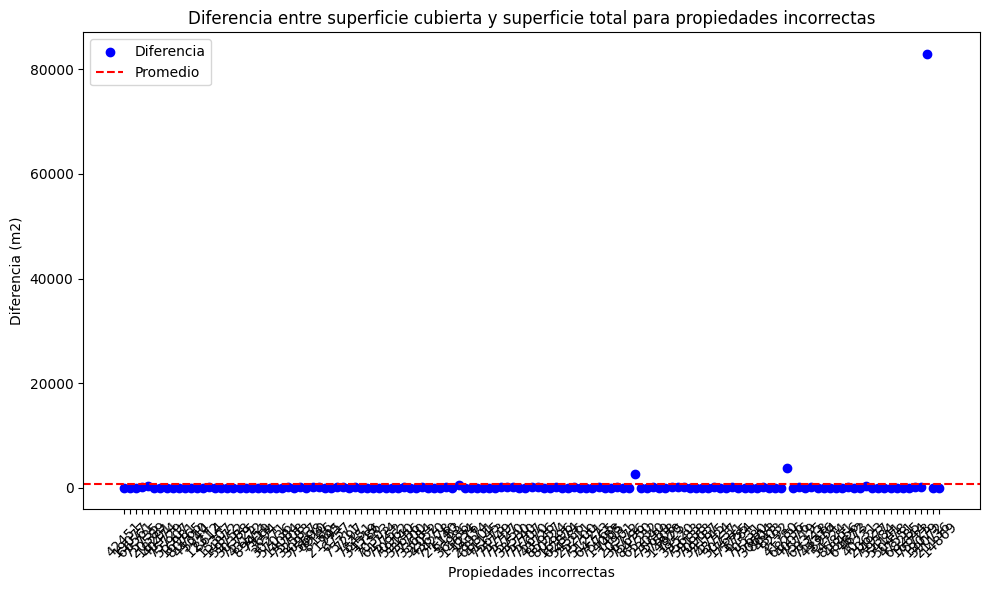

In [21]:
# Crear un gráfico de dispersión para mostrar la diferencia entre superficie cubierta y superficie total
plt.figure(figsize=(10, 6))
plt.scatter(range(len(propiedades_superficie_incorrecta)), propiedades_superficie_incorrecta['diferencia'], color='blue', label='Diferencia')
plt.axhline(promedio_diferencias, color='red', linestyle='--', label='Promedio')
plt.title('Diferencia entre superficie cubierta y superficie total para propiedades incorrectas')
plt.xlabel('Propiedades incorrectas')
plt.ylabel('Diferencia (m2)')
plt.legend()
plt.xticks(range(len(propiedades_superficie_incorrecta)), propiedades_superficie_incorrecta.index, rotation=45)
plt.tight_layout()
plt.show()

Se ve que en su mayoria la diferencia de m2 de property_surface_covered y property_surface_total es baja,salvo por unos outsider, por lo tanto se deduce que se confundieorn de Campo al poner lso tamaños de la propiedad

Asi que lo que se va hacer es intercambiar ambos valores por cada propiedad incorrecta

In [22]:
mask = df_filtrado['property_surface_covered'] > df_filtrado['property_surface_total']


df_filtrado.loc[mask, ['property_surface_covered', 'property_surface_total']] = df_filtrado.loc[mask, ['property_surface_total', 'property_surface_covered']].values

propiedades_superficie_incorrecta = df_filtrado[df_filtrado['property_surface_covered'] > df_filtrado['property_surface_total']]

print(len(propiedades_superficie_incorrecta))

0


Se inputan los atributos rooms y bedrooms que esten Nan

Primero se comprueba que ninguna propiedad tiene ambos atributos en Nan

In [23]:
mask = df_filtrado['property_rooms'].isna() & df_filtrado['property_bedrooms'].isna()


filas_con_ambos_nan = mask.sum()
print(filas_con_ambos_nan)

303


Se borran las propiedades que tiene ambos atributos en Nan

In [24]:
df_filtrado = df_filtrado[~mask]


Se calcula el promedio de property_bedrooms que hay dependiendo de property_rooms





In [25]:
promedio_rooms = df_filtrado[['property_rooms']].mean(skipna=True)
promedio_bedrooms = df_filtrado[['property_bedrooms']].mean(skipna=True)

promerdio = float(promedio_rooms)/float(promedio_bedrooms)
print(promerdio)

1.4047747140349442


Como en las propiedades por lo general hay 1.4 mas rooms que bedrooms, se hace la estimacion de que en la mayoria de propiedades hay un room mas bedrooms, debido que 1.4 tiende mas a uno que a dos, es decir el promedio es que por cada propiedad hay una room de mas comparado los bedrooms

Por lo tanto lo que se hace es buscar las propiedades con Rooms Nan, y inputarle la cantidad de ahbitaciones mas 1(Que nos dio en el promedio)

In [26]:
df_filtrado['property_rooms'].fillna(df_filtrado['property_bedrooms'] + 1, inplace=True)

<ipython-input-26-eaf38500bb99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['property_rooms'].fillna(df_filtrado['property_bedrooms'] + 1, inplace=True)


Ahora se verifica si hay property_rooms con valor 0

In [27]:
propiedades_con_cero_rooms = df_filtrado['property_rooms'] == 0
cantidad_propiedades_con_cero_rooms = propiedades_con_cero_rooms.sum()
print(cantidad_propiedades_con_cero_rooms)

0


Ahora propiedades con 1

In [28]:
propiedades_con_uno_rooms = df_filtrado['property_rooms'] == 1
cantidad_propiedades_con_uno_rooms = propiedades_con_uno_rooms.sum()
print(cantidad_propiedades_con_uno_rooms)

11439


Se hace lo mismo pero con Bedrooms, exceptuando a las propiedades con un solo cuarto(monoambientes)

In [29]:
df_filtrado['property_bedrooms'].fillna(df_filtrado['property_rooms'] - 1, inplace=True)

df_filtrado.loc[df_filtrado['property_rooms'] == 1, 'property_bedrooms'] = 1

mask = df_filtrado['property_rooms'].isna() & df_filtrado['property_bedrooms'].isna()


filas_con_ambos_nan = mask.sum()
print(filas_con_ambos_nan)

0


<ipython-input-29-b04545653e1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['property_bedrooms'].fillna(df_filtrado['property_rooms'] - 1, inplace=True)


Se verifica que no haya 0 dormitorios

In [30]:
propiedades_con_cero_bedrooms = df_filtrado['property_bedrooms'] == 0
cantidad_propiedades_con_cero_bedrooms = propiedades_con_cero_bedrooms.sum()
print(cantidad_propiedades_con_cero_bedrooms)

0


Se verifica que no haya ninguna propiedad con menos de 0 cuartos

In [31]:
cuartos_negativos = df_filtrado['property_rooms'] < 0

cantidad_propiedades_negativas = cuartos_negativos.sum()

print("Cantidad de propiedades con valores menores a 0 en la columna 'property_rooms':", cantidad_propiedades_negativas)

Cantidad de propiedades con valores menores a 0 en la columna 'property_rooms': 0


Que no haya ninguna propiedad con menos de 0 dormitorios

In [32]:
mask = df_filtrado['property_bedrooms'] < 0

df_filtrado.loc[mask, 'property_bedrooms'] = df_filtrado.loc[mask, 'property_rooms'] - 1
#se verica los cambios
dormitorios_negativos = df_filtrado['property_bedrooms'] <0
cantidad_propiedades_negativas = dormitorios_negativos.sum()
print("Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms':", cantidad_propiedades_negativas)

Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms': 0


Se busca que no haya mas dormitorios que habitaciones

In [33]:
indices_correccion = df_filtrado[df_filtrado['property_bedrooms'] > df_filtrado['property_rooms']].index

df_filtrado.loc[indices_correccion, 'property_bedrooms'] = df_filtrado.loc[indices_correccion, 'property_rooms']

indices_correccion_despues = df_filtrado[df_filtrado['property_bedrooms'] > df_filtrado['property_rooms']].index

print("Cantidad de filas corregidas:", len(indices_correccion_despues))


Cantidad de filas corregidas: 0


Siempre hay mas habitaciones que dormitorios

Se verifica devuelta si hay columnas Nan

In [34]:
filas_totales = df_filtrado.shape[0]
print(df_filtrado.isna().sum() / filas_totales * 100)

id                          0.000000
start_date                  0.000000
end_date                    0.000000
created_on                  0.000000
latitud                     0.000000
longitud                    0.000000
place_l2                    0.000000
place_l3                    0.055972
operation                   0.000000
property_type               0.000000
property_rooms              0.000000
property_bedrooms           0.000000
property_surface_total      0.000000
property_surface_covered    0.000000
property_currency           0.000000
property_title              0.000000
property_price              0.000000
dtype: float64


Como se puede ver hay un muy pequeño porcentaje de Propiedades sin barrio. Las cuales se van a borrar ya que no va a afectar al dataset.

In [35]:
df_filtrado = df_filtrado.dropna(subset=["place_l3"])

In [36]:
filas_totales = df_filtrado.shape[0]
print(df_filtrado.isna().sum() / filas_totales * 100)

id                          0.0
start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l2                    0.0
place_l3                    0.0
operation                   0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_currency           0.0
property_title              0.0
property_price              0.0
dtype: float64


# Análisis inicial

### Variables

In [37]:
columnas_cualitativas = [
    "id",
    "place_l2",
    "place_l3",
    "operation",
    "property_type",
    "property_currency",
    "property_title",
]
variables_cualitativas = df_filtrado[columnas_cualitativas]

columnas_cuantitativas_discretas = [
    "start_date",
    "end_date",
    "created_on",
    "property_rooms",
    "property_bedrooms",
    "property_surface_total",
    "property_surface_covered",
    "property_price",
]


columnas_cuantitativas_continuas = [
    "latitud",
    "longitud",
]
variables_cuantitativas_discretas = df_filtrado[columnas_cuantitativas_discretas]

variables_cuantitativas_continuas = df_filtrado[columnas_cuantitativas_continuas]

columnas_cuantitativas = columnas_cuantitativas_discretas+columnas_cuantitativas_continuas

variables_cuantitativas = df_filtrado[columnas_cuantitativas]
variables_cuantitativas = variables_cuantitativas.select_dtypes(include=['float64', 'int64'])


print(len(columnas_cualitativas + columnas_cuantitativas) == df_filtrado.columns.size)

True


Ahora se fija las variables


Comenzando con un Analisis de correlacion


In [38]:
matriz_corr=variables_cuantitativas.corr()
matriz_corr

property_rooms  property_bedrooms  \
property_rooms                  1.000000           0.916622   
property_bedrooms               0.916622           1.000000   
property_surface_total          0.061370           0.061097   
property_surface_covered        0.076167           0.074150   
property_price                  0.487616           0.450968   
latitud                        -0.033356          -0.035649   
longitud                        0.013715           0.012138   

                          property_surface_total  property_surface_covered  \
property_rooms                          0.061370                  0.076167   
property_bedrooms                       0.061097                  0.074150   
property_surface_total                  1.000000                  0.667374   
property_surface_covered                0.667374                  1.000000   
property_price                          0.067060                  0.075971   
latitud                                 0.006786                  0.009734   
longitud                                0.002855                  0.002132   

                          property_price   latitud  longitud  
property_rooms                  0.487616 -0.033356  0.013715  
property_bedrooms               0.450968 -0.035649  0.012138  
property_surface_total          0.067060  0.006786  0.002855  
property_surface_covered        0.075971  0.009734  0.002132  
property_price                  1.000000  0.157552  0.123819  
latitud                         0.157552  1.000000 -0.139439  
longitud                        0.123819 -0.139439  1.000000

<Axes: >

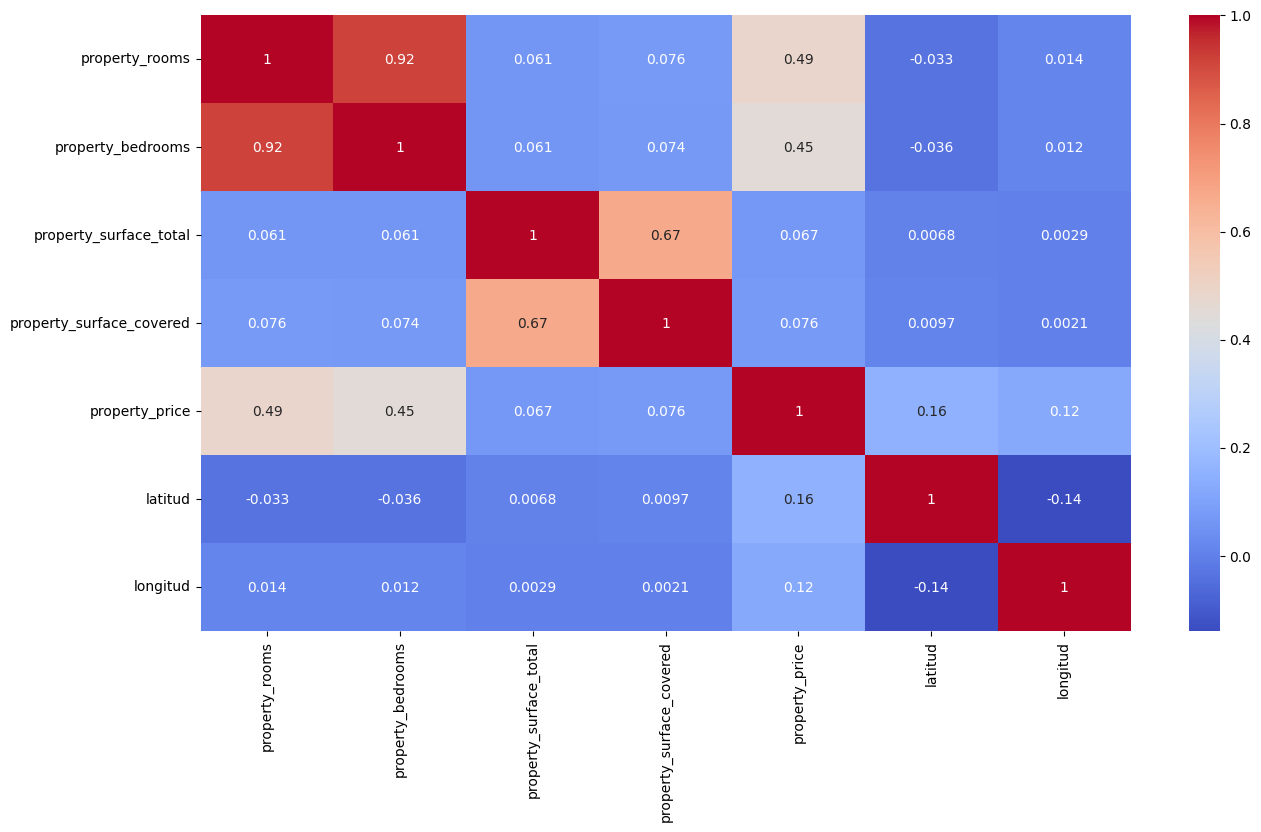

In [39]:
plt.figure(figsize = (15,8))
sns.heatmap(matriz_corr, annot = True, cmap='coolwarm')

Como ningua variable tiene correlacion cercana a 0 con la demas, todas son de utilidas. Exceptuando Latidud y Longitud, pero son importante para el dataset

Estructura general del dataset.

In [40]:
df_filtrado.shape

(71424, 17)

In [41]:
df_filtrado.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_currency            object
property_title               object
property_price              float64
dtype: object

Se calcula las medidas de la variables cuantitativas Primero la media

In [42]:
media = variables_cuantitativas.mean()
print(media)

property_rooms                   2.823169
property_bedrooms                1.901490
property_surface_total         108.933682
property_surface_covered        84.057072
property_price              222029.119246
latitud                        -34.596365
longitud                       -58.438560
dtype: float64


La mediana

In [43]:
mediana = variables_cuantitativas.median()
print(mediana)

property_rooms                   3.000000
property_bedrooms                2.000000
property_surface_total          65.000000
property_surface_covered        57.000000
property_price              142000.000000
latitud                        -34.595998
longitud                       -58.438796
dtype: float64


La moda

In [44]:
moda = variables_cuantitativas.mode()
print(moda)

   property_rooms  property_bedrooms  property_surface_total  \
0             3.0                1.0                    50.0   

   property_surface_covered  property_price   latitud   longitud  
0                      40.0        110000.0 -34.54125 -58.472966  


Desviacion Estandar

In [45]:
desviacion_estandar = variables_cuantitativas.std()
print(desviacion_estandar)

property_rooms                   1.424810
property_bedrooms                1.072122
property_surface_total        1051.328300
property_surface_covered       682.727892
property_price              301205.009138
latitud                          0.026198
longitud                         0.037946
dtype: float64


Rango

In [46]:
rango = variables_cuantitativas.max() - variables_cuantitativas.min()
print(rango)

property_rooms              3.900000e+01
property_bedrooms           3.300000e+01
property_surface_total      1.369988e+05
property_surface_covered    1.229990e+05
property_price              1.199500e+07
latitud                     1.589355e-01
longitud                    1.871521e-01
dtype: float64


Cuantiles

In [47]:
cuantiles = variables_cuantitativas.quantile([0.25, 0.5, 0.75])
print(cuantiles)

      property_rooms  property_bedrooms  property_surface_total  \
0.25             2.0                1.0                    45.0   
0.50             3.0                2.0                    65.0   
0.75             4.0                3.0                   104.0   

      property_surface_covered  property_price    latitud   longitud  
0.25                      40.0         95000.0 -34.616002 -58.465700  
0.50                      57.0        142000.0 -34.595998 -58.438796  
0.75                      87.0        235000.0 -34.577597 -58.408956  


Se analizar las viriables Cualitativas

In [48]:
for variable in variables_cualitativas:

    cantidad_valores = len(vivienda_df[variable].unique())


    print("Cantidad de valores posibles para", variable, ":", cantidad_valores)

Cantidad de valores posibles para id : 71767
Cantidad de valores posibles para place_l2 : 1
Cantidad de valores posibles para place_l3 : 58
Cantidad de valores posibles para operation : 1
Cantidad de valores posibles para property_type : 3
Cantidad de valores posibles para property_currency : 1
Cantidad de valores posibles para property_title : 44538


Variables que no aportan nada:

-Id: Nunca se a requerir el uso de estas, y como se esta trabajando con conjunto de datos, no se va a necesitar el identificador de cada propiedad

-Created_on: Ya existe una variable que cumple la funcion de esta, la cual es Start_date

Se elimina estas 2 variables

In [49]:
columnas_a_eliminar = ["id", "created_on"]
vivienda_df = df_filtrado.drop(columnas_a_eliminar, axis=1)
vivienda_df.head(1)

start_date    end_date    latitud   longitud         place_l2  \
47437  2021-02-11  2021-03-18 -34.630337 -58.411793  Capital Federal   

               place_l3 operation property_type  property_rooms  \
47437  Parque Patricios     Venta  Departamento             2.0   

       property_bedrooms  property_surface_total  property_surface_covered  \
47437                1.0                   139.0                      61.0   

      property_currency                                     property_title  \
47437               USD  VENTA DEPARTAMENTO 2 AMBIENTES CON TERRAZA PRO...   

       property_price  
47437        160000.0

Análisis grafico de las variables mas destacables



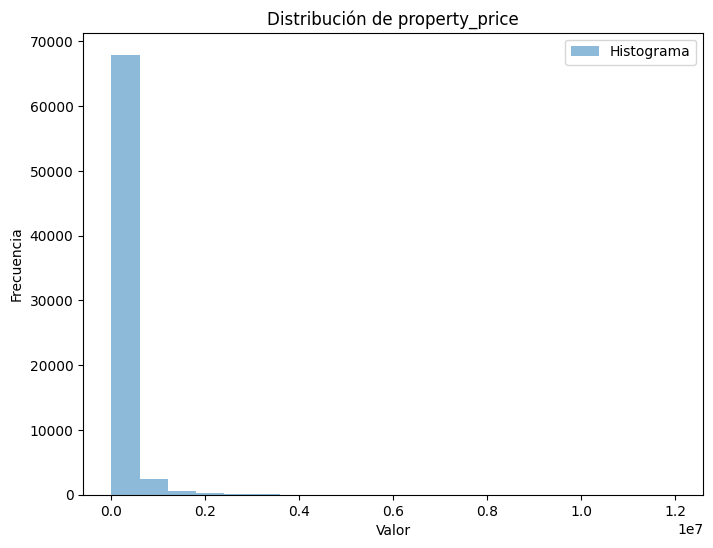

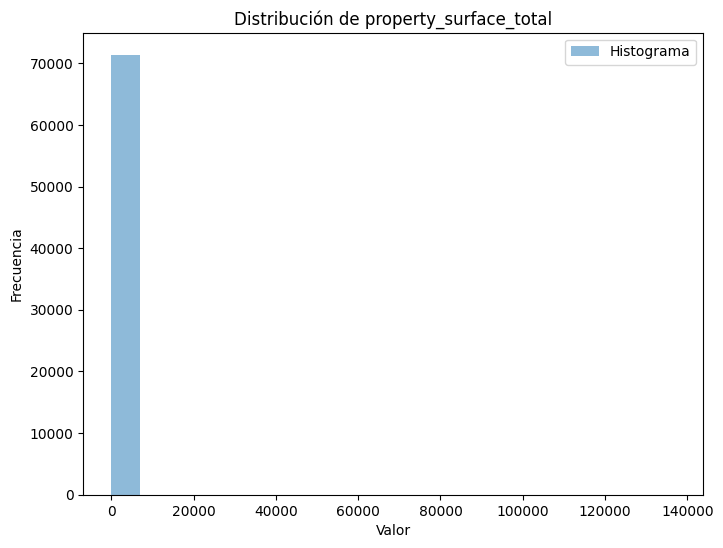

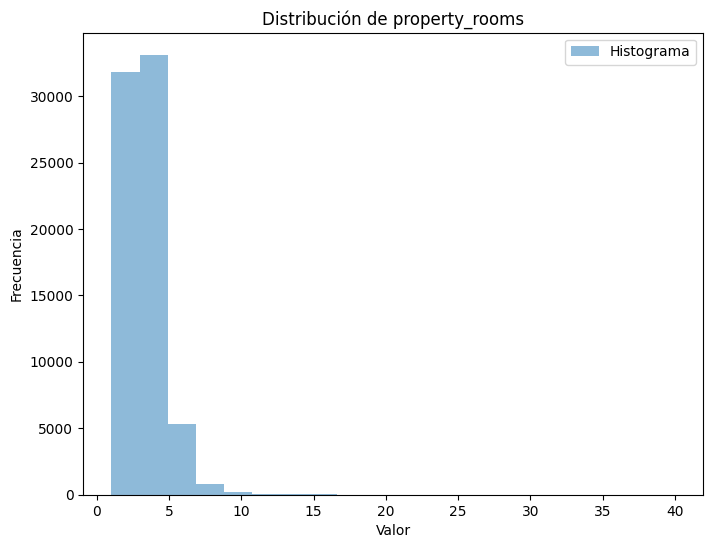

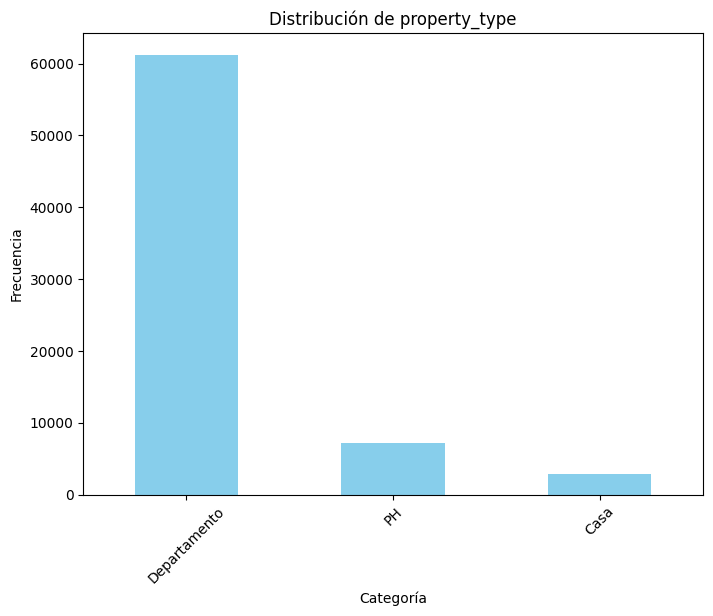

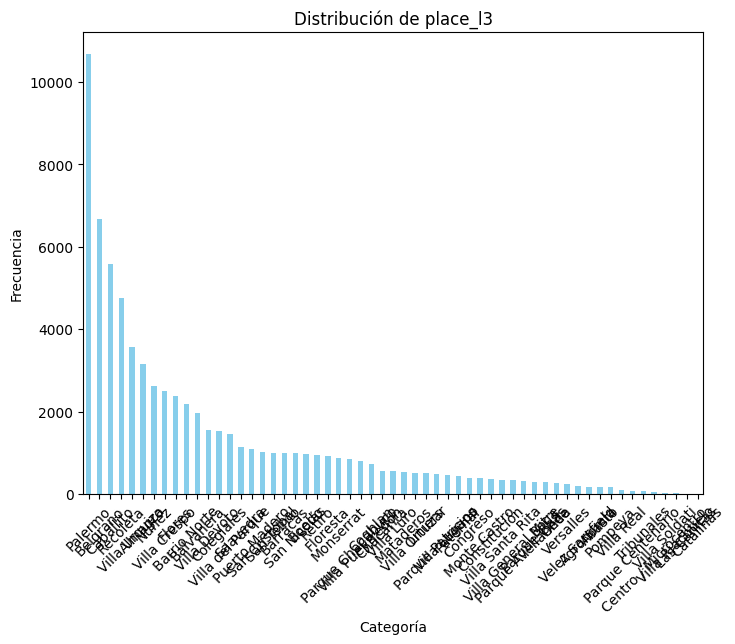

In [50]:
variables_relevantes = ['property_price', 'property_surface_total', 'property_rooms','property_type', 'place_l3']


for variable in variables_relevantes:
    if vivienda_df[variable].dtype in ['int64', 'float64']:
        plt.figure(figsize=(8, 6))
        plt.hist(vivienda_df[variable], bins=20, alpha=0.5, label='Histograma')
        plt.title(f'Distribución de {variable}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()


for variable in variables_relevantes:
    if vivienda_df[variable].dtype == 'object':
        plt.figure(figsize=(8, 6))
        vivienda_df[variable].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'Distribución de {variable}')
        plt.xlabel('Categoría')
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.show()

BarPLot de como las viviendas estan distribuidas por la ciudad

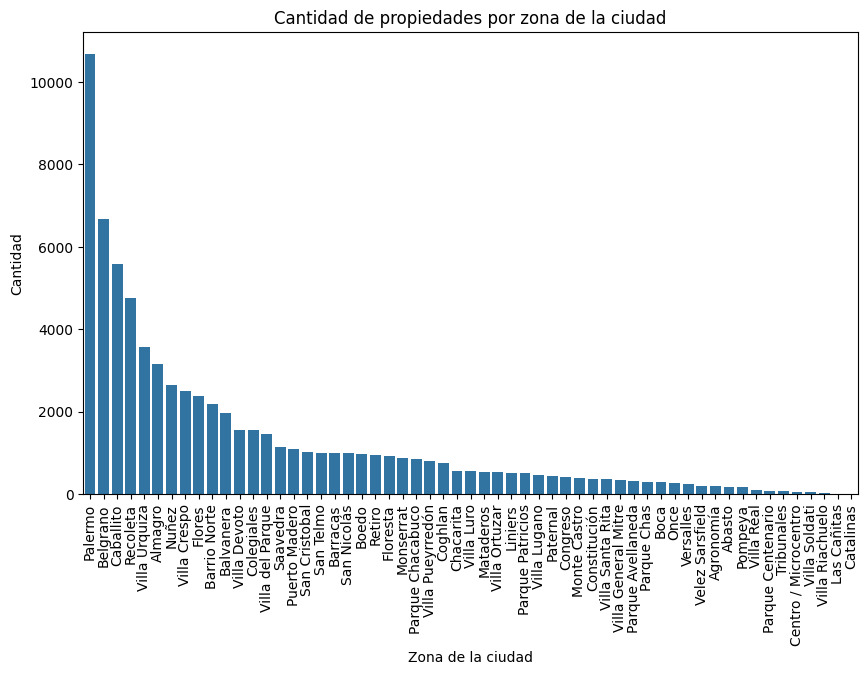

In [51]:
plt.figure(figsize=(10, 6))
sns.countplot(x='place_l3', data=vivienda_df, order=vivienda_df['place_l3'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Zona de la ciudad')
plt.ylabel('Cantidad')
plt.title('Cantidad de propiedades por zona de la ciudad')
plt.show()

Se puede ver que la mayoria de las viviendas se encuentran en Palermo, Belgrano, Caballito y Recoleta

Grafico de torta de la cantidad de departamentos, casas y PH

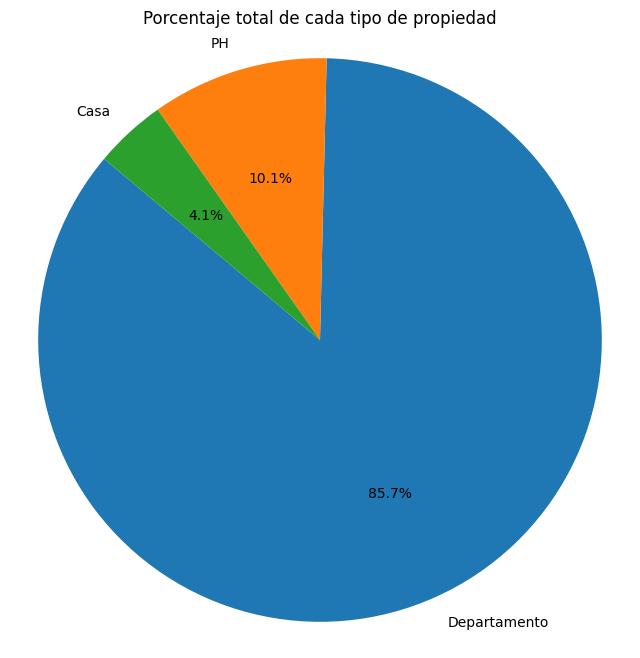

In [52]:
porcentaje_property_type = vivienda_df['property_type'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
plt.pie(porcentaje_property_type, labels=porcentaje_property_type.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Porcentaje total de cada tipo de propiedad')
plt.show()

La gran mayoria de propiedades son departamentos

Analisis de la correlacion entre las variables

Analizó si el precio aumenta dependiendo el tamañano de la vivienda

In [53]:
correlacion_pearson = vivienda_df['property_surface_total'].corr(vivienda_df['property_price'])

print("Correlación de Pearson entre terreno total y precio:", correlacion_pearson)

Correlación de Pearson entre terreno total y precio: 0.06705982483287026


Como el valor es tan cercano a 0, no es linea la relacion del tamaño de la vivienda con su precio

Ahora si la cantidad de habitaciones tiene efecto en el precio de la vivienda

In [54]:
correlacion_pearson = vivienda_df['property_rooms'].corr(vivienda_df['property_price'])

print("Correlación de Pearson entre la cantidad de habitaciones y precio:", correlacion_pearson)

Correlación de Pearson entre la cantidad de habitaciones y precio: 0.4876157234012336


Aca se puede ver una tendencia que entre mas habitaciones, mayor sera el precio de la vivienda, pero en una medida baja, ya que el resultado esta casi justo entre el 0 y el 1. Osea que la correlacion entre estas 2 variables no es extremadamente fuerte.

La correlacion que hay entre el terreno total y la cantidad de habitaicones

In [55]:
correlacion_pearson = vivienda_df['property_surface_total'].corr(vivienda_df['property_rooms'])

print("Correlación de Pearson entre terreno total y la cantidad de habitaciones:", correlacion_pearson)

Correlación de Pearson entre terreno total y la cantidad de habitaciones: 0.061369554953018594


Como el numero esta mas cerca de 0, no hay una correlacion lineal entre el terreno total y la cantidad de habitaciones

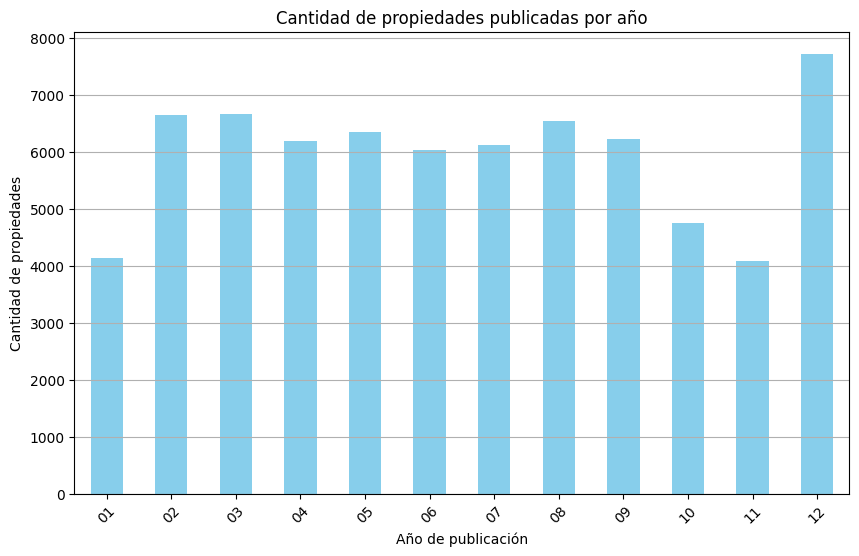

In [56]:
vivienda_df['año_publicacion'] = vivienda_df['start_date'].str.split('-').str[1]

# Contar la cantidad de propiedades publicadas por año
conteo_por_año = vivienda_df['año_publicacion'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_año.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades publicadas por año')
plt.xlabel('Año de publicación')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Se puede ver como el mes donde mas se publicaron Propiedades fue el mes de diciembre

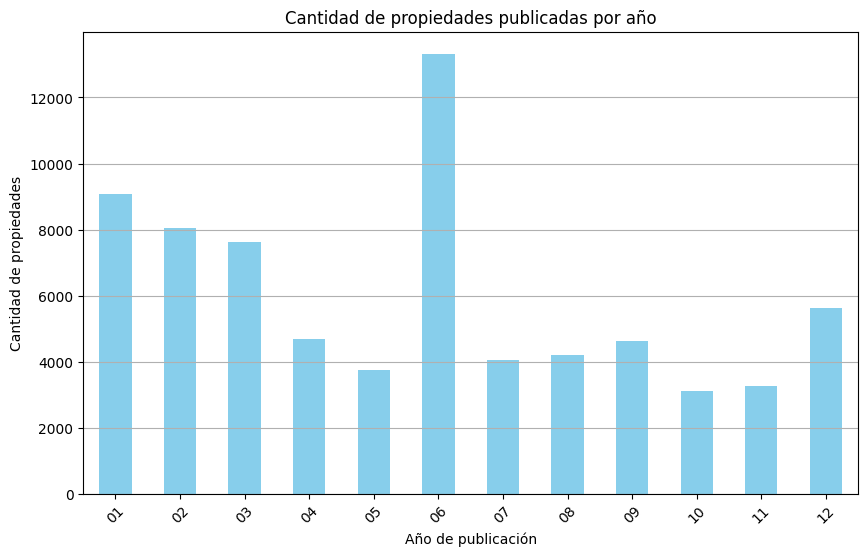

In [57]:
vivienda_df['año_publicacion'] = vivienda_df['end_date'].str.split('-').str[1]

# Contar la cantidad de propiedades publicadas por año
conteo_por_año = vivienda_df['año_publicacion'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_año.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades publicadas por año')
plt.xlabel('Año de publicación')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Junio es el mes donde mas propiedades dejaron de estar publicadas para su alquiler

<Figure size 1000x600 with 0 Axes>

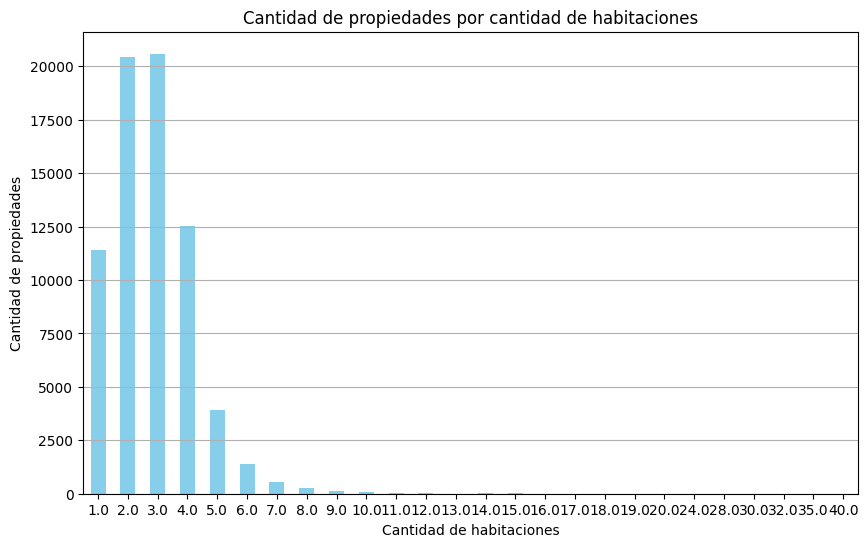

In [58]:
plt.figure(figsize=(10, 6))
conteo_habitaciones = vivienda_df['property_rooms'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_habitaciones.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades por cantidad de habitaciones')
plt.xlabel('Cantidad de habitaciones')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

La mayoria de propiedades oscila entre 2 y 3 habitaciones

<Figure size 1000x600 with 0 Axes>

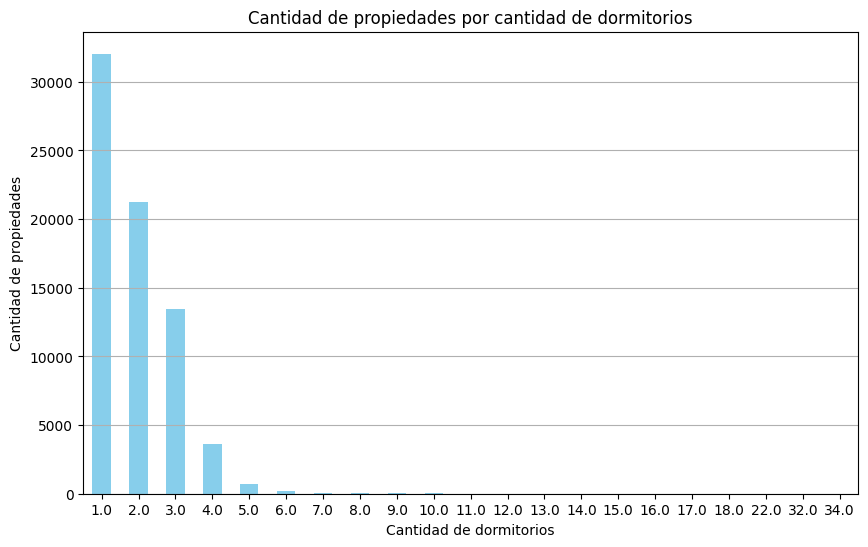

In [59]:
plt.figure(figsize=(10, 6))
conteo_habitaciones = vivienda_df['property_bedrooms'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_habitaciones.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades por cantidad de dormitorios')
plt.xlabel('Cantidad de dormitorios')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

La mayoria de departamentos tienen una sola habitacion

Siempre hay mas habitaciones que dormitorios

# Visualizaciones

In [60]:
df_deptos = vivienda_df.copy()

## Precio vs Cantidades de ambientes

*   Dejando de lado los outliers, se puede notar una campana de Gauss que relaciona la cant de ambientes con la propiedad
*   Se notan outliers cuando hay 15 ambientes o más, o cuando el precio de propiedades es mayor a 5 millones



<Axes: xlabel='property_rooms', ylabel='property_price'>

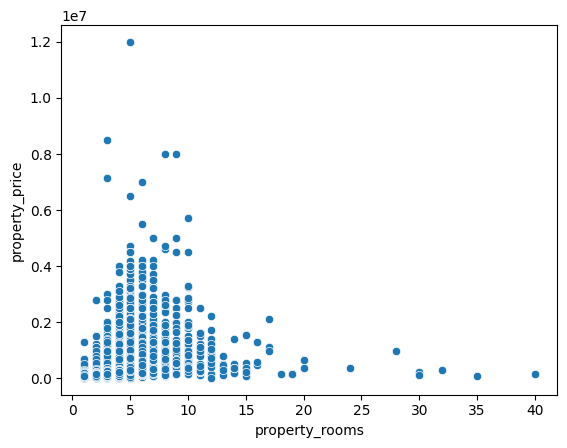

In [61]:
sns.scatterplot(x = df_deptos["property_rooms"], y = df_deptos["property_price"])

## Precio vs Porcentaje de superficie cubierta

El porcentaje de superficie cubierta se calculará de la siguiente forma:
(property_surface_covered/property_surface_total) * 100%

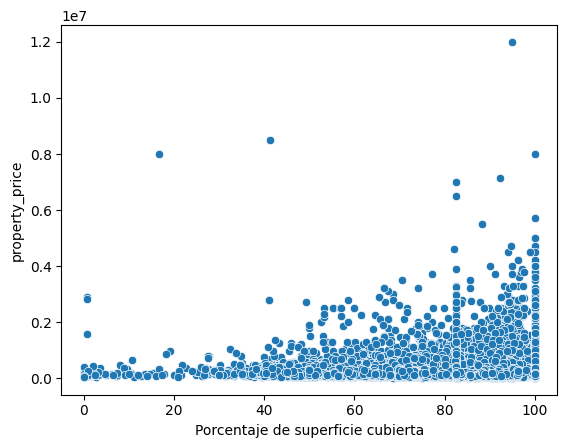

In [62]:
sns.scatterplot(y = df_deptos["property_price"], x = (df_deptos["property_surface_covered"]/df_deptos["property_surface_total"]) * 100)
plt.xlabel("Porcentaje de superficie cubierta")
plt.show()

Podemos ver que el Porcentaje de Superficie Cubierta parece ser un buen indicador para predecir el precio, por lo que lo agregaremos al dataset para ser usado más adelante

In [63]:
df_deptos["property_coverage_percent"] = (df_deptos["property_surface_covered"]/df_deptos["property_surface_total"]) * 100
df_deptos.head(3)

start_date    end_date    latitud   longitud         place_l2  \
47437  2021-02-11  2021-03-18 -34.630337 -58.411793  Capital Federal   
81327  2021-12-16  2022-02-09 -34.637319 -58.361124  Capital Federal   
50802  2021-11-06  2022-01-27 -34.597205 -58.392474  Capital Federal   

               place_l3 operation property_type  property_rooms  \
47437  Parque Patricios     Venta  Departamento             2.0   
81327              Boca     Venta  Departamento             3.0   
50802          Recoleta     Venta  Departamento             3.0   

       property_bedrooms  property_surface_total  property_surface_covered  \
47437                1.0                   139.0                      61.0   
81327                2.0                    58.0                      55.0   
50802                2.0                   133.0                      92.0   

      property_currency                                     property_title  \
47437               USD  VENTA DEPARTAMENTO 2 AMBIENTES CON TERRAZA PRO...   
81327               USD            VENTA TRES AMBIENTES LA BOCA PISO ALTO    
50802               USD      Venta de Departamento 3 Ambientes en Recoleta   

       property_price año_publicacion  property_coverage_percent  
47437        160000.0              03                  43.884892  
81327         74900.0              02                  94.827586  
50802        469200.0              01                  69.172932

## Precios vs Barrio

En este sección comparamos distintas maneras de medir el precio de la propiedad y las compararemos contra los Barrios. Esto tiene dos objetivos:
*   Comparar los precios de los barrios, ya que creemos que el barrio donde se ubica una propiedad afecta considerablemente al precio
*   Ver cual/es método/s de valoración (Precio total, Precio por metro cuadrado, Precio por ambiente) son los más adecuados para poder conocer lo anterior

Viendo los gráficos, se puede concluir que:
*   En general Puerto Madero, Recoleta, Belgrano, Palermo, y Las Cañitas parecen contener las propeidades más caras
*   Precio por metro cuadrado parece ser un método poco adecuado para valorar los barrios, debido a su alta varianza
*   Precio total y Precio por ambiente tienen mucha menos varianza que Precio por metro cuadrado, lo cual las convierte en buenos indicadores del valor promedio de los barrios





### Precio de la propiedad vs Barrio

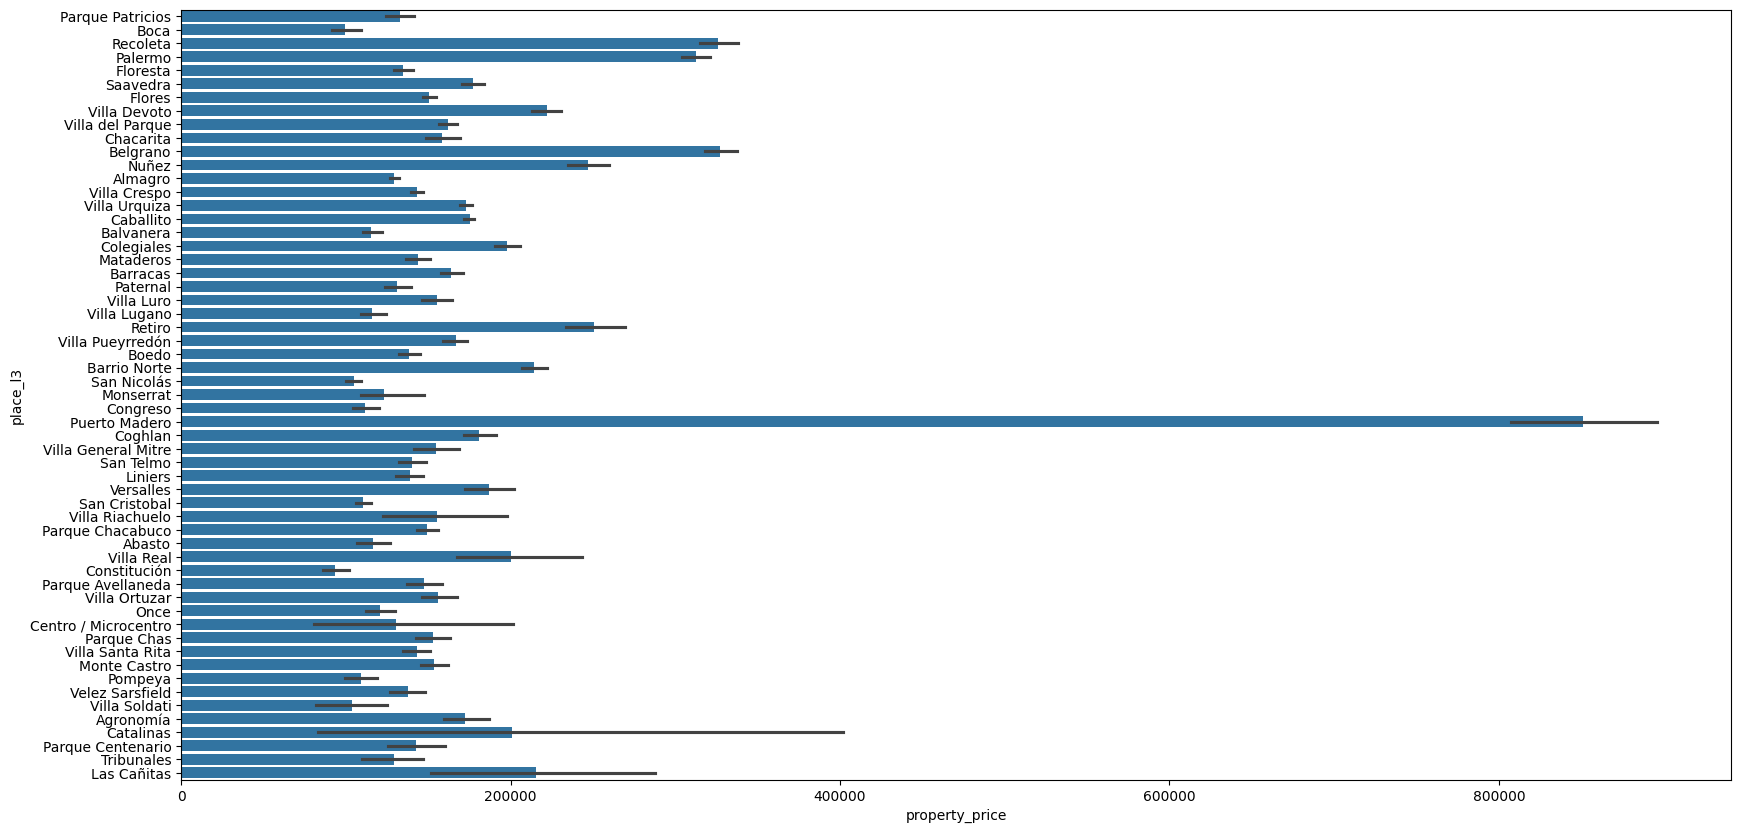

In [64]:
visu_precios_por_barrio = sns.barplot(y = df_deptos["place_l3"], x = df_deptos["property_price"])
visu_precios_por_barrio.figure.set_size_inches(20, 10)

### Precio por metro cuadrado vs Barrio

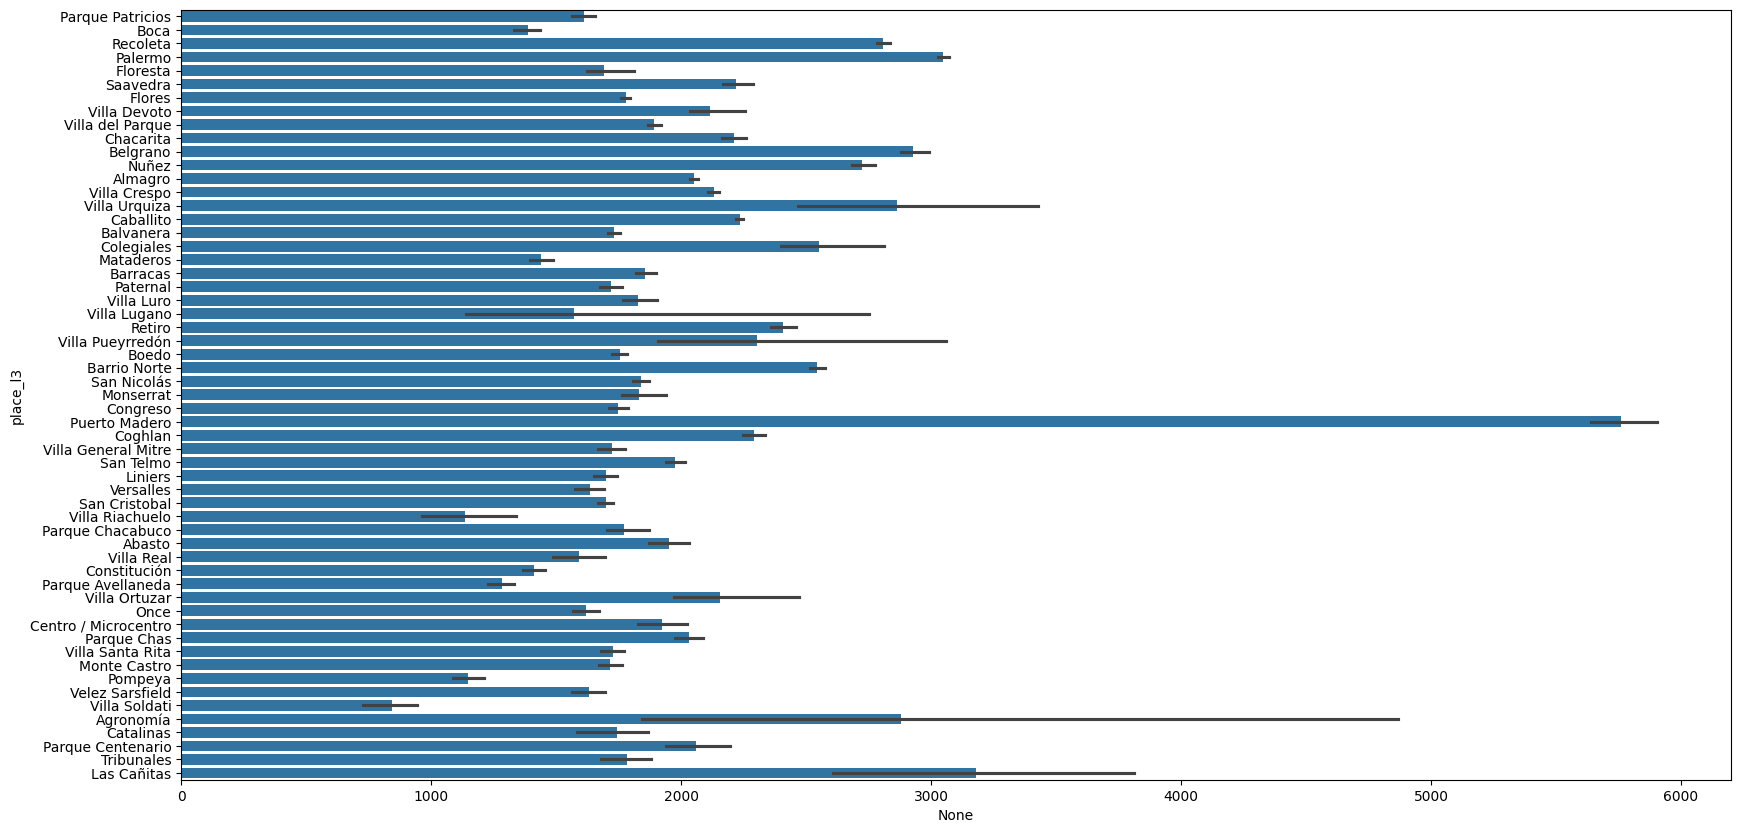

In [65]:
visu_precios_por_barrio = sns.barplot(y = df_deptos["place_l3"], x = (df_deptos["property_price"]/df_deptos["property_surface_total"]))
visu_precios_por_barrio.figure.set_size_inches(20, 10)

### Precio por ambiente vs Barrio

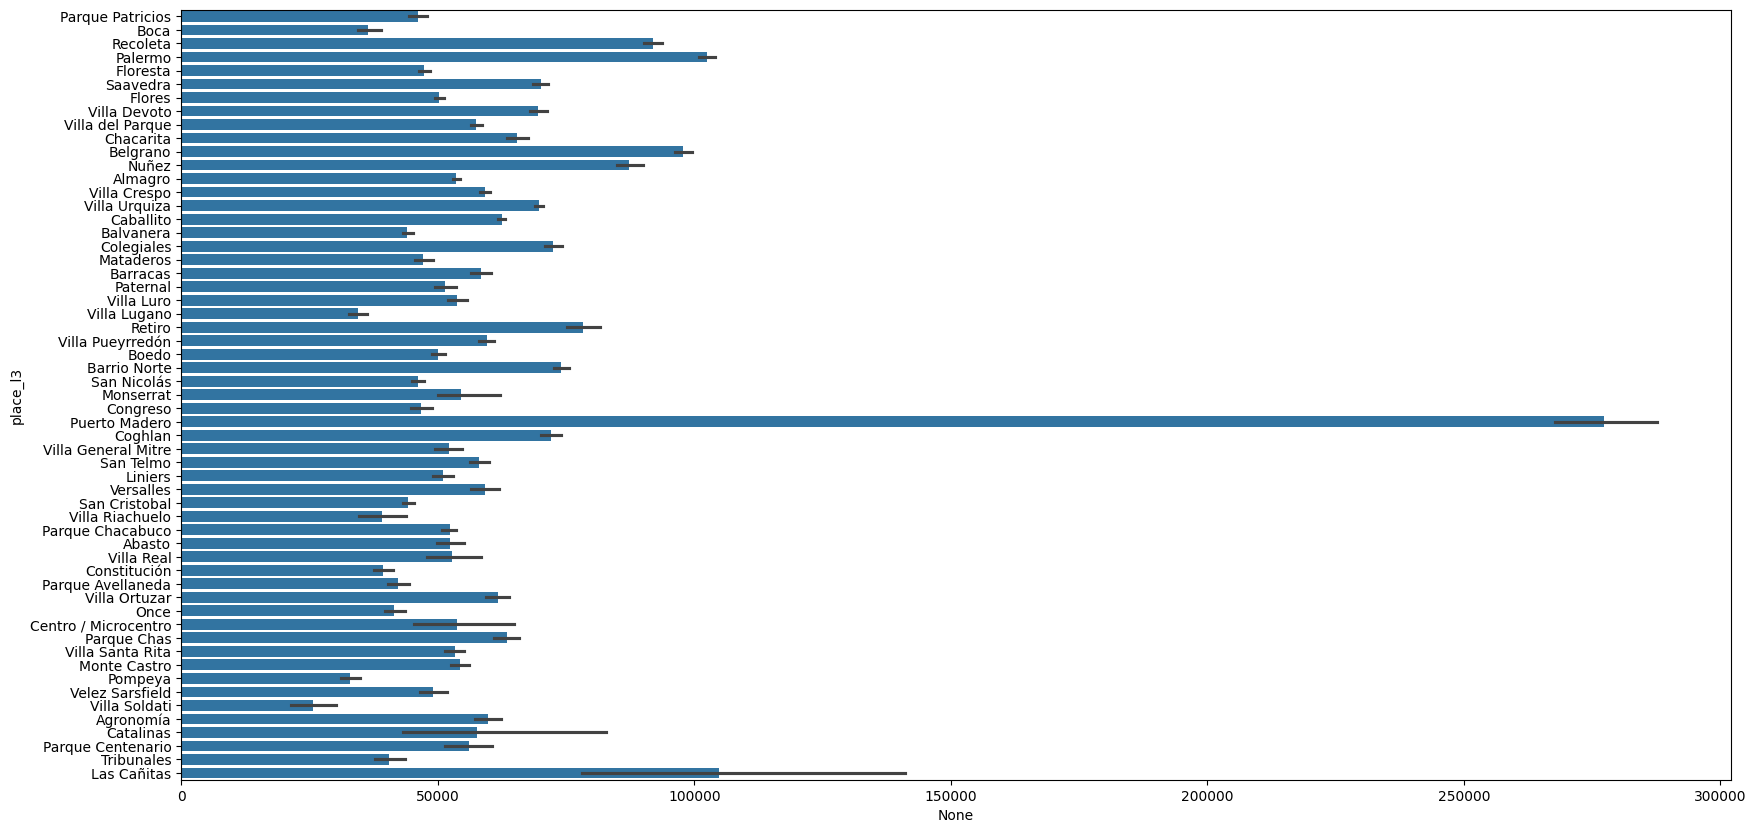

In [66]:
visu_precios_por_barrio = sns.barplot(y = df_deptos["place_l3"], x = (df_deptos["property_price"]/df_deptos["property_rooms"]))
visu_precios_por_barrio.figure.set_size_inches(20, 10)

## Precio por tipo de propiedad

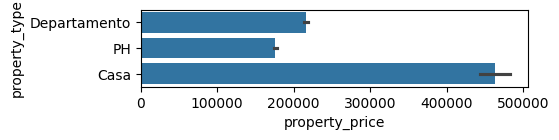

In [67]:
visu_precios_por_tipo = sns.barplot(y = df_deptos["property_type"], x = df_deptos["property_price"])
visu_precios_por_tipo.figure.set_size_inches(5, 1)

# Outliers

En esta sección se examinarán los outliers del dataset

## *Definición de función para LOF*

In [68]:
from sklearn.neighbors import LocalOutlierFactor

# df = dataframe, nombre_col_x = string, nombre_col_y = string, cant_vecinos = int
# Genera un gráfico scatterplot entre nombre_col_x y nombre_col_y donde están expresados los LOF, teniendo en cuenta la cantidad de vecinos proporcionada
# Devuelve un DF que es una copia del DF dado pero solo con nombre_col_x, nombre_col_y, y los LOF scores correspondientes
def graficar_lof(df,nombre_col_x,nombre_col_y,cant_vecinos):
  df_lof = df[[nombre_col_x,nombre_col_y]]

  # Normalizo los valores de X e Y usando Min-Max, para que medir sus distancias sea más certero
  min_x = df_lof[nombre_col_x].min()
  max_x = df_lof[nombre_col_x].max()
  df_lof[nombre_col_x] = (df_lof[nombre_col_x] - min_x) / (max_x - min_x)
  min_y = df_lof[nombre_col_y].min()
  max_y = df_lof[nombre_col_y].max()
  df_lof[nombre_col_y] = (df_lof[nombre_col_y] - min_y) / (max_y - min_y)

  # Conjunto de entrenamiento
  X = df_lof[[nombre_col_x, nombre_col_y]].values

  # Creo el clasificador
  clf = LocalOutlierFactor(n_neighbors=cant_vecinos)

  # Genero prediccion
  y_pred = clf.fit_predict(X)

  # Guardo los scores
  df_lof["scores"] = clf.negative_outlier_factor_

  # Calculo radio para plotear score
  radius = (df_lof["scores"].max() - df_lof["scores"]) / (df_lof["scores"].max() - df_lof["scores"].min())

  # Grafico LOF
  plt.figure(figsize=(10, 10))
  plt.title("Local Outlier Factor (LOF)")
  plt.scatter(
      df_lof[nombre_col_x].values,
      df_lof[nombre_col_y].values,
      edgecolor="grey",
      s=30,
      label="datos",
      facecolors="none",
  )
  plt.scatter(
      df_lof[nombre_col_x].values,
      df_lof[nombre_col_y].values,
      s=1300 * radius,
      edgecolors="red",
      facecolors="none",
      label="Outlier scores",
  )
  legend = plt.legend(loc="upper left")
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]
  plt.show()
  return df_lof

## Ambientes

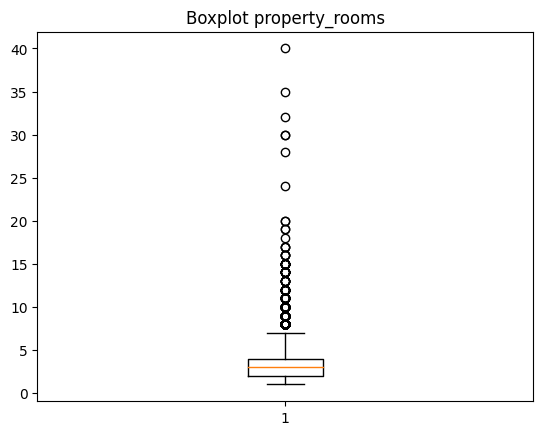

In [69]:
plt.boxplot(df_deptos["property_rooms"])
plt.title("Boxplot property_rooms")
plt.show()

Veamos los outliers moderados (+/- 1,5 * Rango intercuartil)

In [70]:
# Cuartiles
Q1_altura = np.quantile(df_deptos.property_rooms, 0.25)
Q3_altura = np.quantile(df_deptos.property_rooms, 0.75)

# Rango intercuartil
IQR_altura = Q3_altura - Q1_altura

# Limite inferior Outliers
out_inf = Q1_altura - 1.5 * IQR_altura

# Limite superior Outliers
out_sup = Q1_altura + 1.5 * IQR_altura

out_inf, out_sup

(-1.0, 5.0)

In [71]:
# Outliers moderados
df_deptos[(df_deptos["property_rooms"] <= out_inf) | (df_deptos["property_rooms"] >= out_sup)].shape

(6460, 17)

Ya que los moderados son muchos (Las propiedades de 5 o más ambientes son comunes) veamos los extremos (+/- 3 * Rango intercuartil)

In [72]:
# Limite inferior Outliers
out_inf_ex = Q1_altura - 3 * IQR_altura

# Limite superior Outliers
out_sup_ex = Q1_altura + 3 * IQR_altura

out_inf_ex, out_sup_ex

(-4.0, 8.0)

In [73]:
# Outliers extremos
df_deptos[(df_deptos["property_rooms"] <= out_inf_ex) | (df_deptos["property_rooms"] >= out_sup_ex)].shape

(568, 17)

Como se puede ver, los outliers extremos son mucho menos frecuentes, pero aún así una vivienda con 8 ambientes es razonable. Sin embargo, el boxplot sugiere que las viviendas de aproximadamente 10 ambientes o más son escasas. Echemos un vistazo:

In [74]:
df_deptos[(df_deptos["property_rooms"] <= out_inf_ex) | (df_deptos["property_rooms"] >= out_sup_ex)]["property_rooms"].value_counts()

property_rooms
8.0     260
9.0     114
10.0     83
11.0     35
12.0     25
15.0     13
14.0     12
13.0      7
16.0      4
17.0      3
19.0      2
30.0      2
20.0      2
40.0      1
24.0      1
32.0      1
35.0      1
18.0      1
28.0      1
Name: count, dtype: int64

In [75]:
df_deptos[df_deptos["property_rooms"] >= 11]

start_date    end_date    latitud   longitud         place_l2  \
13934  2021-09-23  2022-03-09 -34.609264 -58.377884  Capital Federal   
81973  2021-12-16  2022-03-25 -34.581483 -58.434970  Capital Federal   
24424  2021-09-25  2021-09-26 -34.600688 -58.514393  Capital Federal   
12694  2021-05-15  2021-05-18 -34.580976 -58.495637  Capital Federal   
19077  2021-07-02  2021-07-28 -34.658535 -58.481791  Capital Federal   
...           ...         ...        ...        ...              ...   
8883   2021-04-21  2021-05-26 -34.594375 -58.380131  Capital Federal   
38275  2021-07-26  9999-12-31 -34.612036 -58.415431  Capital Federal   
34741  2021-03-23  2021-06-05 -34.627279 -58.373637  Capital Federal   
18890  2021-09-24  2022-03-09 -34.612216 -58.384667  Capital Federal   
30287  2021-12-09  2022-01-27 -34.632730 -58.434728  Capital Federal   

               place_l3 operation property_type  property_rooms  \
13934         Monserrat     Venta  Departamento            11.0   
81973           Palermo     Venta            PH            12.0   
24424      Villa Devoto     Venta          Casa            15.0   
12694  Villa Pueyrredón     Venta          Casa            11.0   
19077         Mataderos     Venta          Casa            12.0   
...                 ...       ...           ...             ...   
8883             Retiro     Venta  Departamento            11.0   
38275           Almagro     Venta            PH            11.0   
34741          Barracas     Venta          Casa            15.0   
18890         Monserrat     Venta  Departamento            15.0   
30287  Parque Chacabuco     Venta          Casa            12.0   

       property_bedrooms  property_surface_total  property_surface_covered  \
13934               10.0                   295.0                     295.0   
81973                9.0                   558.0                     418.0   
24424               10.0                   428.0                     348.0   
12694               11.0                   341.0                     341.0   
19077               10.0                   400.0                     370.0   
...                  ...                     ...                       ...   
8883                 8.0                   676.0                     493.0   
38275                9.0                   370.0                     280.0   
34741               14.0                  2500.0                    2500.0   
18890               14.0                   268.0                     268.0   
30287                6.0                   654.0                     520.0   

      property_currency                                     property_title  \
13934               USD  Venta departamento de 10 ambientes en Monserra...   
81973               USD  PH venta Palermo Hollywood jardín apto profesi...   
24424               USD          Venta casa geriátrico en lote 8,66x29,45    
12694               USD   Casa, cochera, terrazas, patio, Villa Pueyrredón   
19077               USD                                   Casa - Mataderos   
...                 ...                                                ...   
8883                USD  Excelente duplex en edificio francés de gran c...   
38275               USD                                       PH - Almagro   
34741               USD         Casa de 2500 m2, ideal para uso comercial.   
18890               USD  Piso en Venta en Monserrat - Ideal Hostel - A ...   
30287               USD  Casa 12 ambientes en venta en Parque Chacabuco...   

       property_price año_publicacion  property_coverage_percent  
13934        380000.0              03                 100.000000  
81973        850000.0              03                  74.910394  
24424        390000.0              09                  81.308411  
12694        360000.0              05                 100.000000  
19077        130000.0              07                  92.500000  
...               ...             ...                        

Efectivamente. Además, entre los domicilios se pueden ver hoteles y datos mal ingresados (por ejemplo, un departamento en Palermo que dice tener 4 ambientes, pero tiene 40 como valor en property_rooms). Por la baja fiabilidad de este subconjunto, además de su reducido tamaño, decidimos eliminarlo

In [76]:
df_deptos = df_deptos[df_deptos["property_rooms"] < 11]
df_deptos.shape

(71313, 17)

## Ambientes vs Dormitorios

Después de eliminar los outliers de ambientes, se puede ver que los outliers de Dormitorios también han desaparecido (Ya que los dos tienen correlación alta). Además, eliminar outliers en este caso no sería conveniente ya que:
*   En la vida real, diversas propiedades pueden tener diversas cantidades de
dormitorios en relación a ambientes
*   Los casos donde Ambientes==Dormitorios pueden deberse al hecho de que cualquiera de los ambientes pueden usarse como dormitorios si el comprador de la propiedad lo desea

<Axes: xlabel='property_rooms', ylabel='property_bedrooms'>

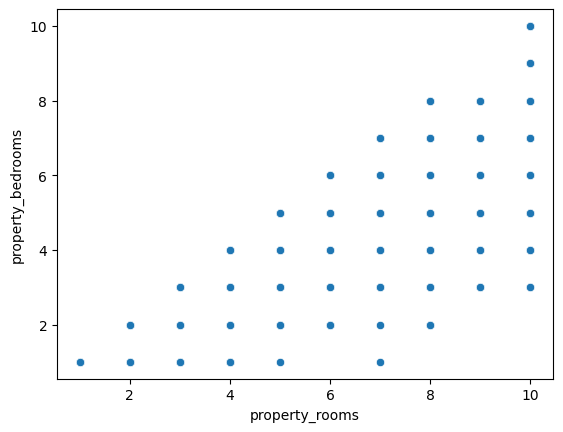

In [77]:
sns.scatterplot(x = df_deptos["property_rooms"], y = df_deptos["property_bedrooms"])

## Precio vs Porcentaje de superficie cubierta

Volvemos a la visualización que hicimos antes, y analizamos sus outliers

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

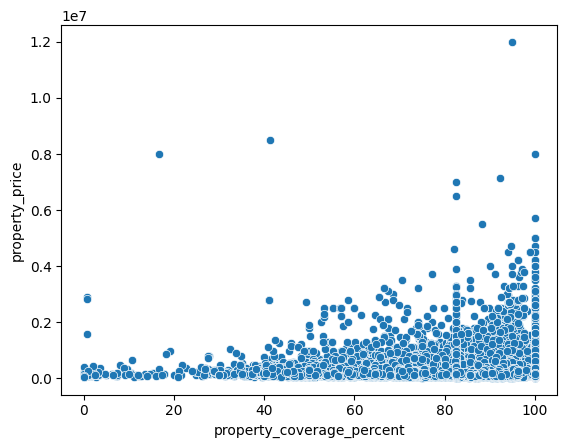

In [78]:
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

Primero veamos los outliers más obvios, comenzando por las propiedades con precio mayor a 6 millones

In [79]:
df_deptos[df_deptos["property_price"]>=6000000]

start_date    end_date    latitud   longitud         place_l2  \
69862  2021-01-16  2021-10-09 -34.614977 -58.362648  Capital Federal   
48154  2021-09-13  2021-09-16 -34.596801 -58.383768  Capital Federal   
43430  2021-09-14  2022-06-05 -34.552226 -58.439016  Capital Federal   
29458  2021-05-12  2021-05-14 -34.565947 -58.442326  Capital Federal   
16996  2021-03-26  2021-06-05 -34.572494 -58.462433  Capital Federal   
59556  2021-03-04  2021-06-05 -34.616918 -58.359927  Capital Federal   
30895  2021-02-17  2021-02-19 -34.608300 -58.371200  Capital Federal   

            place_l3 operation property_type  property_rooms  \
69862  Puerto Madero     Venta  Departamento             5.0   
48154       Recoleta     Venta  Departamento             8.0   
43430       Belgrano     Venta  Departamento             6.0   
29458       Belgrano     Venta          Casa             9.0   
16996       Belgrano     Venta          Casa             5.0   
59556  Puerto Madero     Venta  Departamento             3.0   
30895      Monserrat     Venta          Casa             3.0   

       property_bedrooms  property_surface_total  property_surface_covered  \
69862                3.0              739.189765                     610.0   
48154                2.0              900.000000                     150.0   
43430                4.0              605.893250                     500.0   
29458                5.0             1763.000000                    1763.0   
16996                4.0             3367.000000                    3197.0   
59556                2.0              128.000000                     118.0   
30895                2.0              225.000000                      93.0   

      property_currency                                     property_title  \
69862               USD                      Departamento en Puerto Madero   
48154               USD                            Departamento - Recoleta   
43430               USD                            Departamento - Belgrano   
29458               USD  Casa  Estilo Frances en Venta y/o Alquiler | V...   
16996               USD                                  Casa - Belgrano R   
59556               USD                       Departamento - Puerto Madero   
30895               USD  Oportunidad al Costo! Venta Preciosa Casa a Es...   

       property_price año_publicacion  property_coverage_percent  
69862       6500000.0              10                  82.522788  
48154       8000000.0              09                  16.666667  
43430       7000000.0              06                  82.522788  
29458       8000000.0              05                 100.000000  
16996      12000000.0              06                  94.950995  
59556       7149999.0              06                  92.187500  
30895       8500000.0              02                  41.333333

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

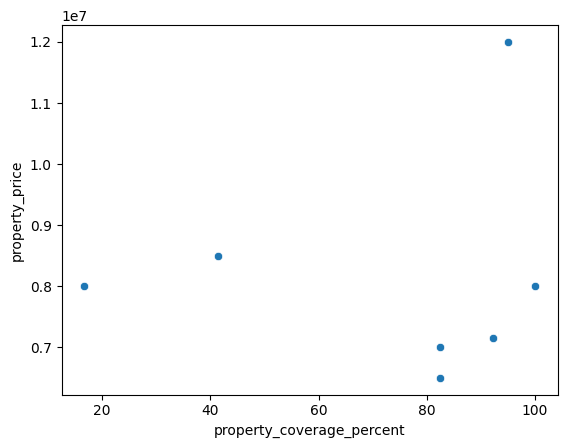

In [80]:
sns.scatterplot(y = df_deptos[df_deptos["property_price"]>=6000000]["property_price"], x = df_deptos["property_coverage_percent"])

Si bien podemos ver algunos barrios caros como Puerto Madero y Belgrano, los eliminamos ya que son un número muy pequeño de outliers

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

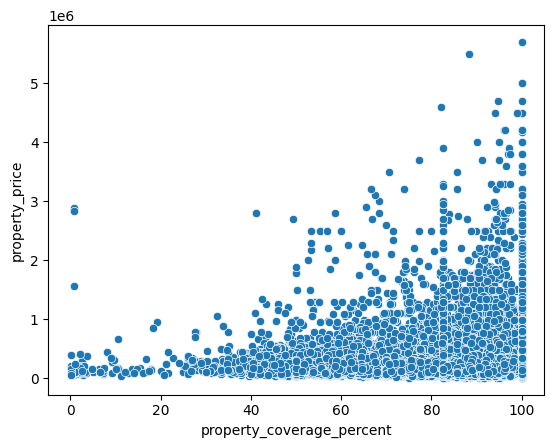

In [81]:
df_deptos = df_deptos[df_deptos["property_price"] < 6000000]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

Ahora veamos los outliers de la izquierda, donde el precio es mayor a 1 millón pero el porcentaje de cobertura es muy bajo

In [82]:
df_deptos[(df_deptos["property_price"] > 1000000) & (df_deptos["property_coverage_percent"] < 10)]

start_date    end_date    latitud   longitud         place_l2 place_l3  \
71216  2021-04-24  2021-06-05 -34.571747 -58.422612  Capital Federal  Palermo   
71214  2021-04-24  2021-06-05 -34.571747 -58.422612  Capital Federal  Palermo   
71218  2021-04-24  2021-06-05 -34.571747 -58.422612  Capital Federal  Palermo   

      operation property_type  property_rooms  property_bedrooms  \
71216     Venta  Departamento             5.0                4.0   
71214     Venta  Departamento             4.0                3.0   
71218     Venta  Departamento             5.0                4.0   

       property_surface_total  property_surface_covered property_currency  \
71216                 42110.0                     307.0               USD   
71214                 42110.0                     307.0               USD   
71218                 42110.0                     307.0               USD   

                                          property_title  property_price  \
71216  Reventa - Departamento - Palermo Nuevo - Liber...       2890500.0   
71214  Reventa - Departamento - Palermo Nuevo - Liber...       1568760.0   
71218  Reventa - Departamento - Palermo Nuevo - Liber...       2829000.0   

      año_publicacion  property_coverage_percent  
71216              06                   0.729043  
71214              06                   0.729043  
71218              06                   0.729043

Si bien son de Palermo, un barrio caro, es muy extraño que un departamento tenga tan poca superficie cubierta y sea tan caro, por lo que los eliminaremos

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

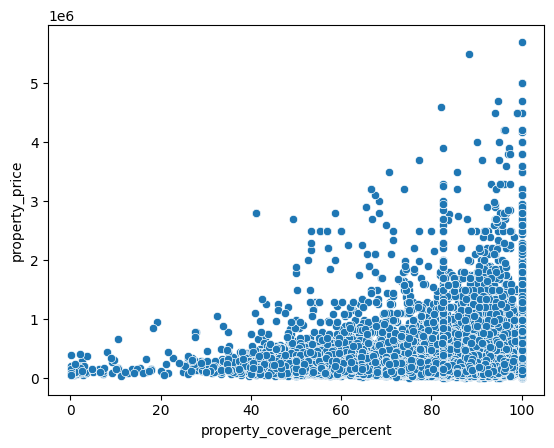

In [83]:
df_deptos = df_deptos[~((df_deptos["property_price"] > 1000000) & (df_deptos["property_coverage_percent"] < 10))]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

El resto de outliers los veremos con LOF

<ipython-input-68-19cc9415282a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_x] = (df_lof[nombre_col_x] - min_x) / (max_x - min_x)
<ipython-input-68-19cc9415282a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_y] = (df_lof[nombre_col_y] - min_y) / (max_y - min_y)
<ipython-input-68-19cc9415282a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

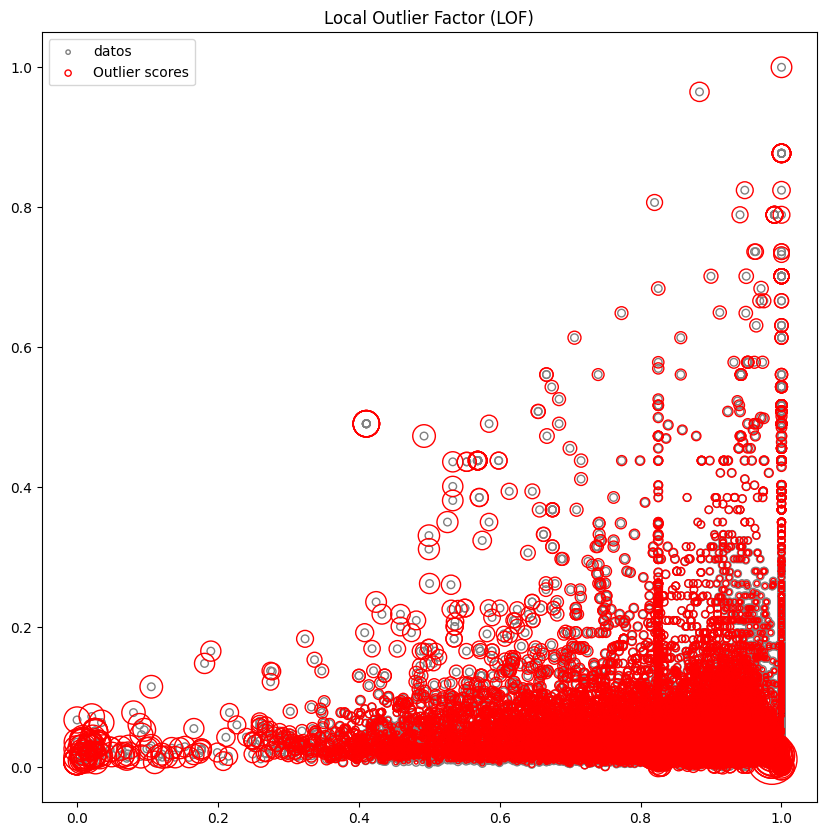

In [84]:
df_lof = graficar_lof(df_deptos,"property_coverage_percent","property_price",600)

Probando varios umbrales de LOF concluimos que -1.7 es el indicado para encontrar un equilibrio entre eliminar los outliers más severos y no eliminar demasiadas entradas, lo cual se puede ver en el siguiente gráfico

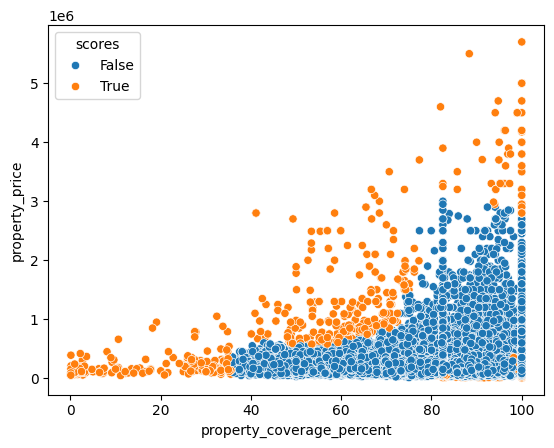

Hay un total de 1519 outliers


In [85]:
es_outlier = df_lof["scores"] <= -1.7
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"], hue=es_outlier)
plt.show()
print("Hay un total de", df_lof[es_outlier].shape[0], "outliers")

Podemos ver que entre los outliers hay más casas y PHs que en los inliers, sin embargo la diferencia no es sustancial

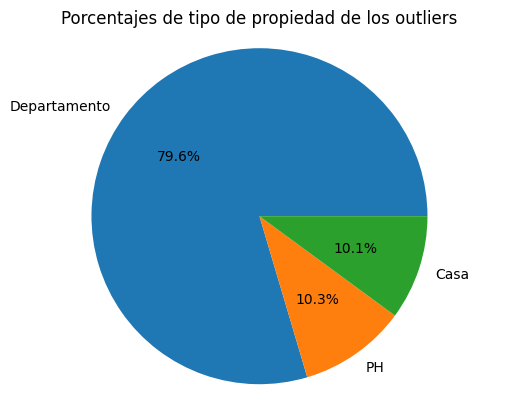

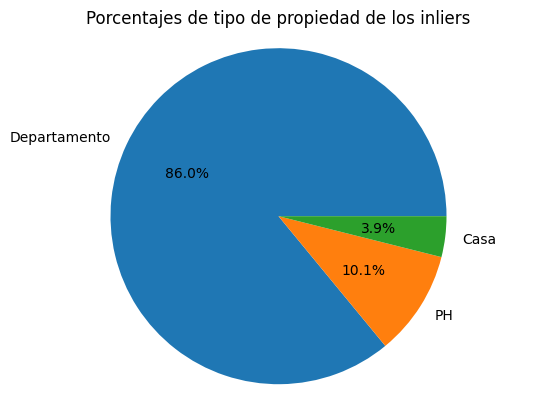

In [86]:
outliers_property_type = df_deptos[es_outlier]['property_type'].value_counts() * 100

plt.pie(outliers_property_type, labels=outliers_property_type.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Porcentajes de tipo de propiedad de los outliers')
plt.show()

no_outliers_property_type = df_deptos[~es_outlier]['property_type'].value_counts() * 100

plt.pie(no_outliers_property_type, labels=no_outliers_property_type.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Porcentajes de tipo de propiedad de los inliers')
plt.show()

Debido a la reducida cantidad de outliers con respecto al resto del conjunto, además de que los mismos no varían mucho del resto del conjunto, procedemos a eliminarlos

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

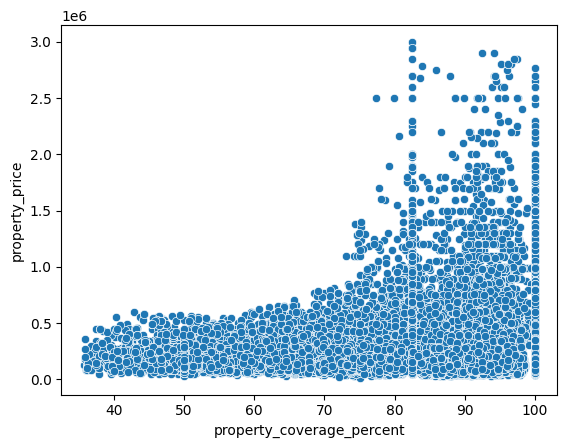

In [87]:
df_deptos = df_deptos[~es_outlier]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

## Superficie total

### Método Boxplot

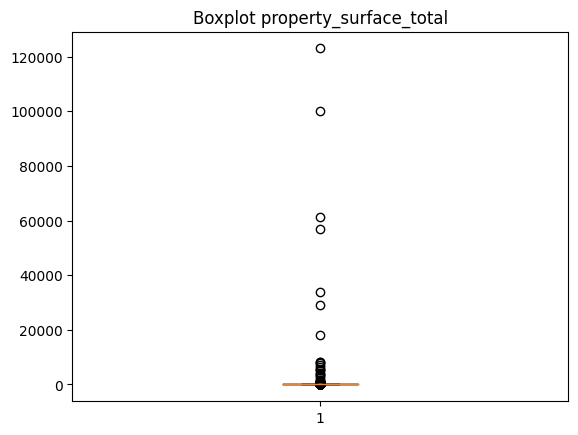

In [88]:
plt.boxplot(df_deptos["property_surface_total"])
plt.title("Boxplot property_surface_total")
plt.show()

Veremos sus outliers moderados y extremos

In [89]:
# Cuartiles
Q1_altura = np.quantile(df_deptos["property_surface_total"], 0.25)
Q3_altura = np.quantile(df_deptos["property_surface_total"], 0.75)

# Rango intercuartil
IQR_altura = Q3_altura - Q1_altura

# Limite inferior Outliers
out_inf = Q1_altura - 1.5 * IQR_altura

# Limite superior Outliers
out_sup = Q1_altura + 1.5 * IQR_altura

# Outliers moderados
df_deptos[(df_deptos["property_surface_total"] <= out_inf) | (df_deptos["property_surface_total"] >= out_sup)].shape[0]

11577

In [90]:
# Limite inferior Outliers
out_inf_ex = Q1_altura - 3 * IQR_altura

# Limite superior Outliers
out_sup_ex = Q1_altura + 3 * IQR_altura

# Outliers extremos
df_deptos[(df_deptos["property_surface_total"] <= out_inf_ex) | (df_deptos["property_surface_total"] >= out_sup_ex)].shape[0]

4006

Son demasiados outliers, por lo que recurriremos a otro método

### Método Z-score

Usamos metodo Z-score modificado, ya que el método Boxplot nos dá demasiados outliers. Además, eligiremos un umbral de |Z|>12 por esa misma razón.

In [91]:
def z_mod_calculation(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

df_deptos_zscore = df_deptos.copy()

df_deptos_zscore["zm_property_surface_total"] =  z_mod_calculation(df_deptos_zscore["property_surface_total"])

outliers_zscore = (df_deptos_zscore["zm_property_surface_total"] > 12) | (df_deptos_zscore["zm_property_surface_total"] < -12)

df_deptos_zscore[outliers_zscore].shape[0]

236

La propiedad con menor superficie entre los outliers tiene la siguiente superficie

In [92]:
df_deptos_zscore[outliers_zscore]["property_surface_total"].min()

494.0

Las propiedades que no fueron detectadas como outliers tienen la siguiente distribución

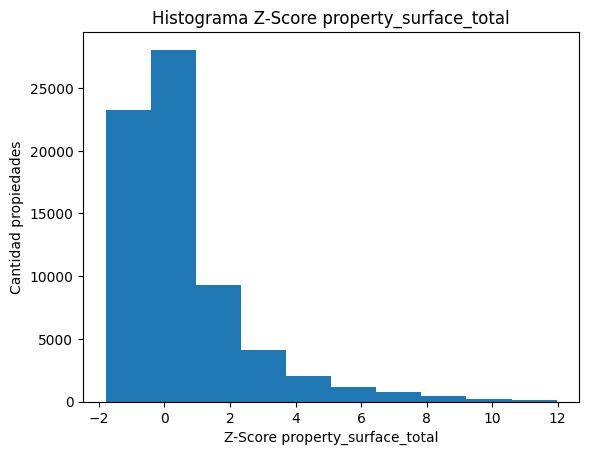

In [93]:
plt.hist(df_deptos_zscore[~outliers_zscore]["zm_property_surface_total"])
plt.title("Histograma Z-Score property_surface_total")
plt.xlabel("Z-Score property_surface_total")
plt.ylabel("Cantidad propiedades")
plt.show()

Procedemos a eliminar los outliers ya que son escasos, además que las propiedades con demasiada superficie podrían afectar la predicción del precio

In [94]:
df_deptos = df_deptos[~outliers_zscore]
df_deptos.shape

(69548, 17)

## Superficie Total vs Cubierta

Si bien parecen haber outliers en esta relación, decidimos no tratarlos ya que diversas propiedades pueden tener diversos porcentajes de superficie cubierta debido a decisiones arquitectónicas distintas para cada propiedad


<Axes: xlabel='property_surface_total', ylabel='property_surface_covered'>

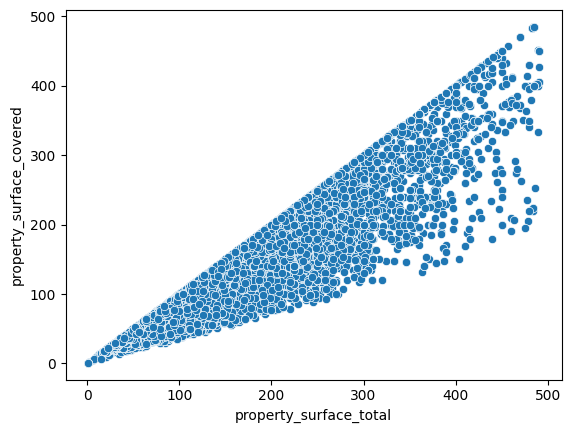

In [95]:
sns.scatterplot(x = df_deptos["property_surface_total"], y = df_deptos["property_surface_covered"])

## Precio vs Superficie total *(Obligatorio)*

Como pide el ejercicio, veremos si quedan outliers analizando Precio vs Superficie total

<Axes: xlabel='property_surface_total', ylabel='property_price'>

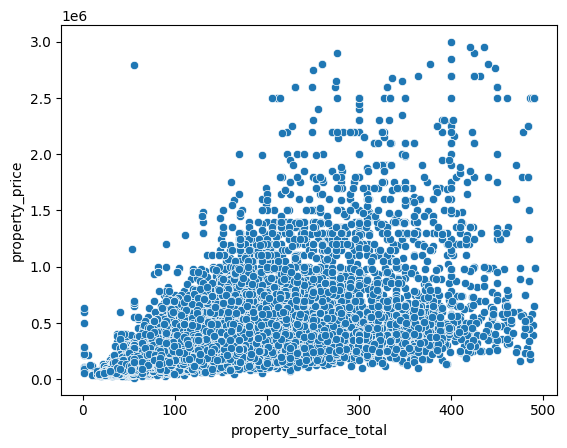

In [96]:
sns.scatterplot(x = df_deptos["property_surface_total"], y = df_deptos["property_price"])

Calculamos outliers con LOF

<ipython-input-68-19cc9415282a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_x] = (df_lof[nombre_col_x] - min_x) / (max_x - min_x)
<ipython-input-68-19cc9415282a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_y] = (df_lof[nombre_col_y] - min_y) / (max_y - min_y)
<ipython-input-68-19cc9415282a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

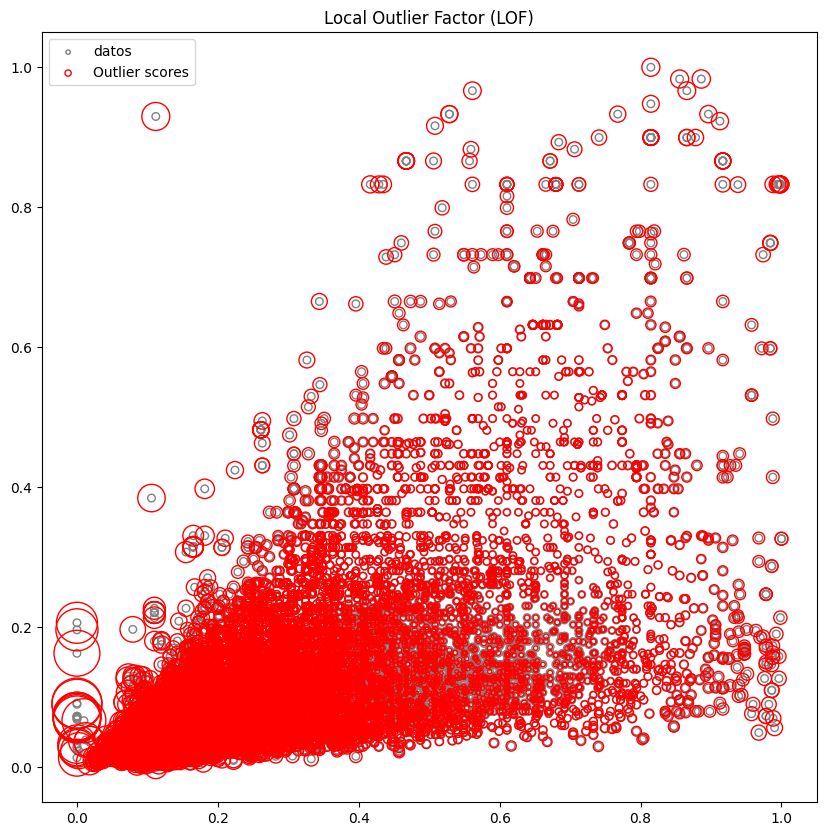

In [97]:
df_lof_pr_sup = graficar_lof(df_deptos,"property_surface_total","property_price",600)

Probando varios umbrales de LOF concluimos que -1.4 es el indicado para encontrar un equilibrio entre eliminar los outliers más severos y no eliminar demasiadas entradas, lo cual se puede ver en el siguiente gráfico.

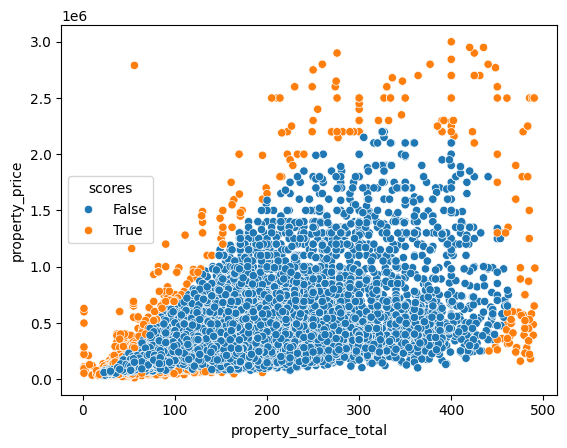

Hay un total de 1510 outliers


In [98]:
es_outlier = df_lof_pr_sup["scores"] <= -1.4
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_surface_total"], hue=es_outlier)
plt.show()
print("Hay un total de", df_deptos[es_outlier].shape[0], "outliers")

Además, esto tiene el efecto de eliminar las propiedades que tienen valores absurdos de Precio por Metro Cuadrado, lo cual será útil en la etapa de clasificación.
Procedemos a eliminarlos.

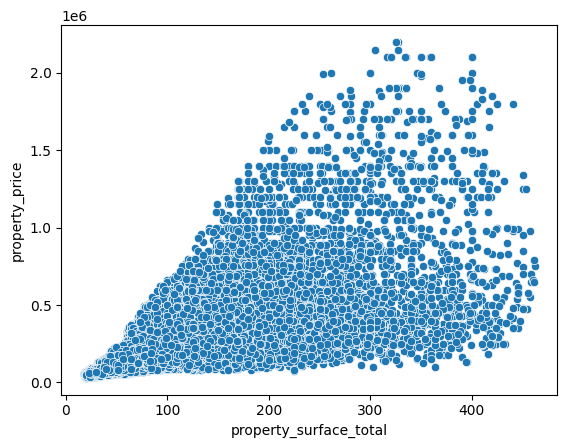

In [99]:
df_deptos = df_deptos[~es_outlier]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_surface_total"])
plt.show()

# Preproceso para agrupación



In [100]:
zona_kmeans_df = df_deptos.copy()
zona_save_col_df = df_deptos.copy()

In [101]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
property_type_ohe = ohe.fit_transform(zona_kmeans_df[['property_type']]).toarray()

In [102]:
property_type_ohe_df = pd.DataFrame(property_type_ohe, columns=['property_type_'+x for x in ohe.categories_[0]])


Reseteamos los index para hacer concat

In [103]:
zona_kmeans_df = zona_kmeans_df.reset_index()

In [104]:
zona_kmeans_concat_df = pd.concat([zona_kmeans_df, property_type_ohe_df], axis=1)

In [105]:
zona_kmeans_concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68038 entries, 0 to 68037
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       68038 non-null  int64  
 1   start_date                  68038 non-null  object 
 2   end_date                    68038 non-null  object 
 3   latitud                     68038 non-null  float64
 4   longitud                    68038 non-null  float64
 5   place_l2                    68038 non-null  object 
 6   place_l3                    68038 non-null  object 
 7   operation                   68038 non-null  object 
 8   property_type               68038 non-null  object 
 9   property_rooms              68038 non-null  float64
 10  property_bedrooms           68038 non-null  float64
 11  property_surface_total      68038 non-null  float64
 12  property_surface_covered    68038 non-null  float64
 13  property_currency           680

place_l2, operation, place_l3, Se van a eliminar, la primera y la segunda por que son valores únicos y place_l3 por que son muchos.

In [106]:
zona_kmeans_concat_df["operation"].unique()

array(['Venta'], dtype=object)

In [107]:
zona_kmeans_concat_df["place_l2"].unique()

array(['Capital Federal'], dtype=object)

In [108]:
zona_kmeans_concat_df["place_l3"].unique()

array(['Parque Patricios', 'Boca', 'Recoleta', 'Palermo', 'Floresta',
       'Saavedra', 'Villa Devoto', 'Villa del Parque', 'Chacarita',
       'Flores', 'Belgrano', 'Nuñez', 'Almagro', 'Villa Crespo',
       'Villa Urquiza', 'Caballito', 'Balvanera', 'Colegiales',
       'Mataderos', 'Paternal', 'Barracas', 'Villa Luro', 'Villa Lugano',
       'Retiro', 'Villa Pueyrredón', 'Boedo', 'Barrio Norte',
       'San Nicolás', 'Congreso', 'Puerto Madero', 'San Telmo',
       'Villa General Mitre', 'Liniers', 'Versalles', 'San Cristobal',
       'Villa Riachuelo', 'Villa Real', 'Parque Chacabuco', 'Coghlan',
       'Monserrat', 'Constitución', 'Parque Avellaneda', 'Villa Ortuzar',
       'Once', 'Centro / Microcentro', 'Parque Chas', 'Villa Santa Rita',
       'Abasto', 'Monte Castro', 'Pompeya', 'Velez Sarsfield',
       'Agronomía', 'Catalinas', 'Parque Centenario', 'Tribunales',
       'Villa Soldati', 'Las Cañitas'], dtype=object)

In [109]:
zona_kmeans_concat_df["año_publicacion"].unique()

array(['03', '02', '01', '04', '06', '08', '07', '05', '10', '11', '12',
       '09'], dtype=object)

También eliminamos property_price.

In [111]:
zona_kmeans_concat_df = zona_kmeans_concat_df[["latitud", "longitud", "property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_coverage_percent", "property_type_Departamento", "property_type_PH"]]

In [112]:
zona_kmeans_concat_df = zona_kmeans_concat_df.dropna()

In [113]:
zona_save_col_2_df = zona_kmeans_concat_df.copy()

In [114]:
from sklearn.preprocessing import MinMaxScaler

for column in zona_kmeans_concat_df.columns:
    scaler = MinMaxScaler()
    zona_kmeans_concat_df[column] = scaler.fit_transform(zona_kmeans_concat_df[[column]])

In [115]:
#Transformo toda as columnas en np.float32
for column in zona_kmeans_concat_df.columns:
    zona_kmeans_concat_df[column] = zona_kmeans_concat_df[column].astype(np.float32)

# Agrupación


### Busqueda del k metodo del codo


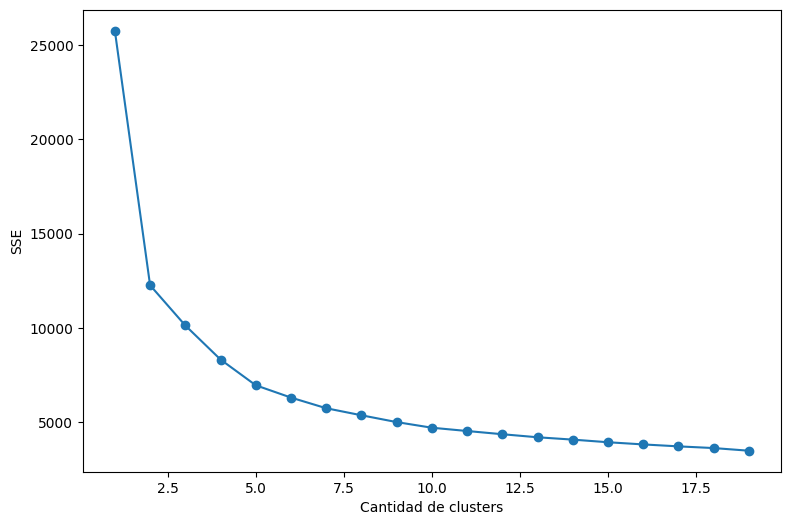

In [116]:
from sklearn.cluster import KMeans
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=k)
    km.fit(zona_kmeans_concat_df)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(9, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

### Mejor k encotrado k = 2 es para nosotros.


In [117]:
labels = KMeans(2, random_state=3).fit_predict(zona_kmeans_concat_df)

labels

array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

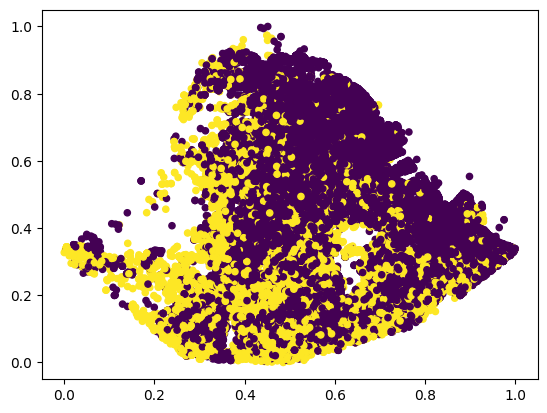

In [118]:
plt.scatter(zona_kmeans_concat_df['latitud'], zona_kmeans_concat_df['longitud'], c=labels, s=20, cmap='viridis')
plt.show()

### Metrica de los primeros 5 ks

In [119]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(zona_kmeans_concat_df)

    score = silhouette_score (zona_kmeans_concat_df, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.6385863
For n_clusters =3 silhouette score is 0.61232644
For n_clusters =4 silhouette score is 0.29982597
For n_clusters =5 silhouette score is 0.2759431


### Gráfico con k= en un mapa de la Ciudad Autónoma de Buenos Aires.

##### Añadir las etiquetas de cluster al DataFrame

In [120]:
zona_kmeans_concat_df_tres = zona_kmeans_concat_df.copy()

In [121]:
kmeans = KMeans(n_clusters=2, random_state=3)
zona_kmeans_concat_df['cluster'] = kmeans.fit_predict(zona_kmeans_concat_df)

###### Desnormalizo las columnas latitud y longitud

In [122]:
zona_kmeans_concat_df['latitud'] = zona_save_col_df['latitud']
zona_kmeans_concat_df['longitud'] = zona_save_col_df['longitud']

In [123]:
zona_kmeans_concat_df

latitud   longitud  property_rooms  property_bedrooms  \
0     -34.637319 -58.361124        0.111111           0.000000   
1     -34.628647 -58.361871        0.222222           0.111111   
2     -34.610027 -58.401934        0.222222           0.111111   
3     -34.631621 -58.416825        0.333333           0.222222   
4            NaN        NaN        0.000000           0.000000   
...          ...        ...             ...                ...   
68033        NaN        NaN        0.222222           0.111111   
68034 -34.594572 -58.430920        0.222222           0.111111   
68035        NaN        NaN        0.555556           0.333333   
68036 -34.590694 -58.435681        0.222222           0.111111   
68037 -34.603523 -58.437103        0.111111           0.000000   

       property_surface_total  property_surface_covered  \
0                    0.272523                  0.114094   
1                    0.090090                  0.100671   
2                    0.259009                  0.183445   
3                    0.142319                  0.127517   
4                    0.106839                  0.098434   
...                       ...                       ...   
68033                0.193694                  0.201342   
68034                0.146396                  0.163311   
68035                0.522523                  0.425056   
68036                0.171171                  0.151166   
68037                0.085586                  0.078300   

       property_coverage_percent  property_type_Departamento  \
0                       0.127098                         1.0   
1                       0.919540                         1.0   
2                       0.520468                         1.0   
3                       0.728132                         1.0   
4                       0.728132                         1.0   
...                          ...                         ...   
68033                   0.940171                         1.0   
68034                   1.000000                         1.0   
68035                   0.688889                         0.0   
68036                   0.728132                         1.0   
68037                   0.694444                         1.0   

       property_type_PH  cluster  
0                   0.0        0  
1                   0.0        0  
2                   0.0        0  
3                   0.0        0  
4                   0.0        0  
...                 ...      ...  
68033               0.0        0  
68034               0.0        0  
68035               0.0        1  
68036               0.0        0  
68037               0.0        0  

[68038 rows x 10 columns]

##### Grafico

<ipython-input-124-b4a8acd94663>:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):


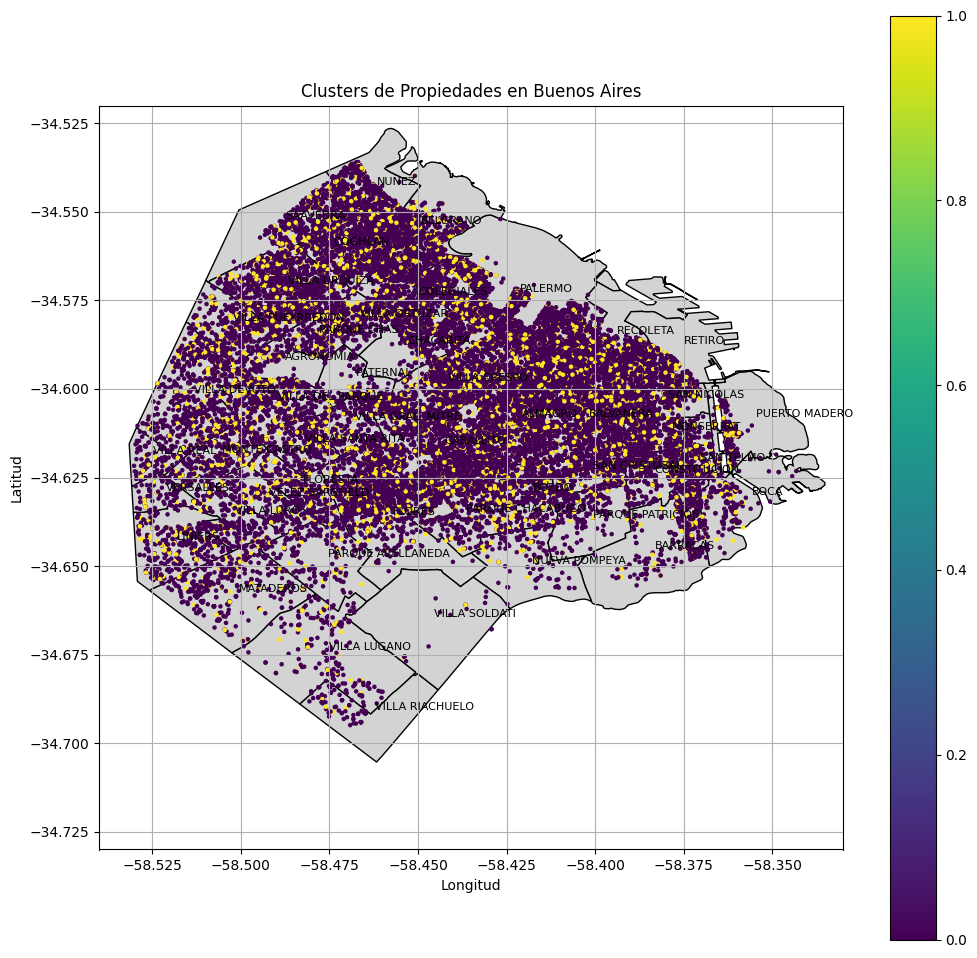

In [124]:
# Creamos una geometría Point para cada punto de latitud y longitud
geometry = [Point(xy) for xy in zip(zona_kmeans_concat_df['longitud'], zona_kmeans_concat_df['latitud'])]


# Creamos un GeoDataFrame con los datos y la geometría
gdf_clusters = gpd.GeoDataFrame(zona_kmeans_concat_df, geometry=geometry)


# Descargamos los datos geoespaciales de Buenos Aires
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)


# Filtramos solo los barrios de la Ciudad Autónoma de Buenos Aires
gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]


# Creamos el mapa base de Buenos Aires
fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')


# Graficamos los puntos de latitud y longitud coloreados por cluster
gdf_clusters.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, legend=True)

# Agregamos etiquetas a los barrios
for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)


# Configuramos el aspecto del mapa
ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
#Agregamos cuadrícula
ax.grid(True)

plt.show()

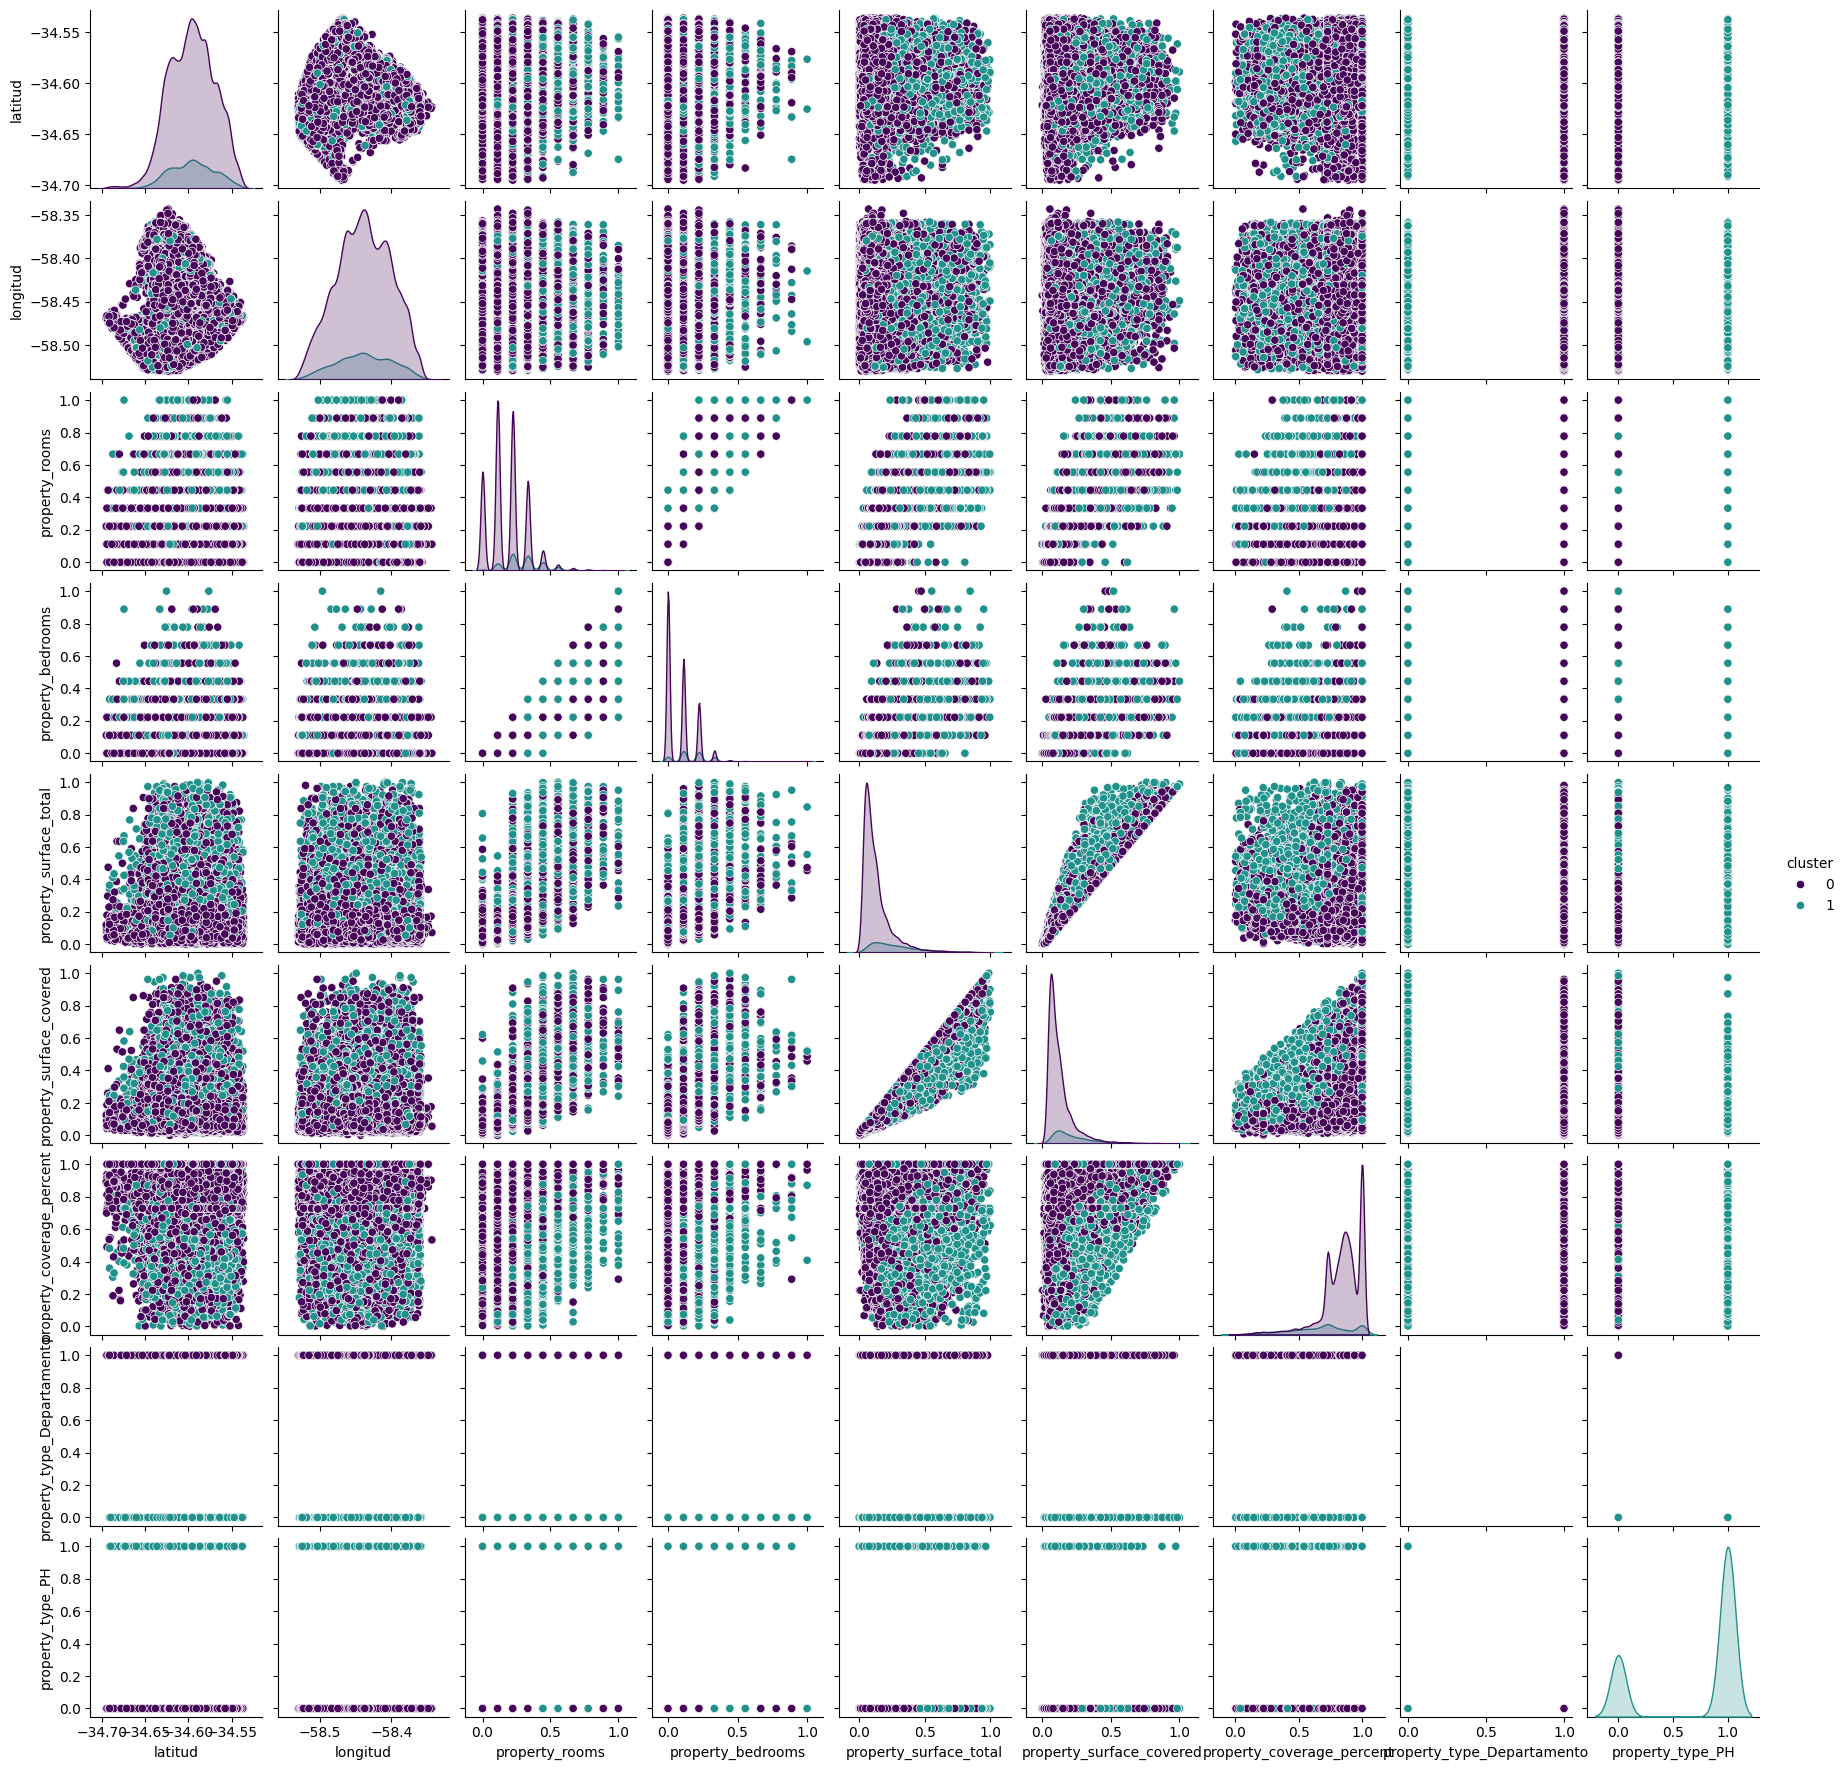

In [125]:
# Asignamos colores a los diferentes valores de la columna "cluster"
colores = {0: '#450457', 1: '#21918C'}

# Utilizamos el parámetro "hue" para asignar los colores en base a la columna "cluster"
sns.pairplot(zona_kmeans_concat_df, height=2, hue="cluster", palette=colores)

### Ahora hacemos los gráficos para k=*3*

In [126]:
labels = KMeans(3, random_state=3).fit_predict(zona_kmeans_concat_df_tres)

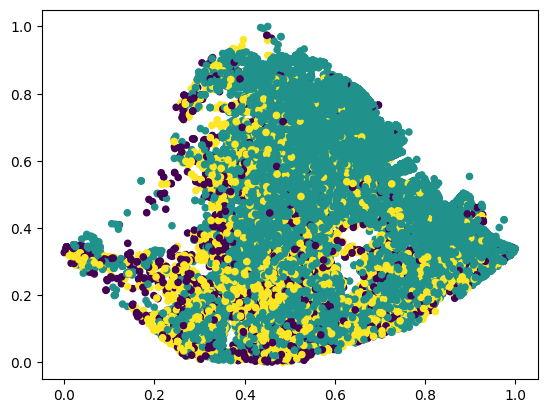

In [127]:
plt.scatter(zona_kmeans_concat_df_tres['latitud'], zona_kmeans_concat_df_tres['longitud'], c=labels, s=20, cmap='viridis')
plt.show()

In [128]:
zona_kmeans_concat_df_tres['cluster'] = labels

In [129]:
zona_kmeans_concat_df_tres['latitud'] = zona_save_col_df['latitud']
zona_kmeans_concat_df_tres['longitud'] = zona_save_col_df['longitud']

<ipython-input-130-18574688602e>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):


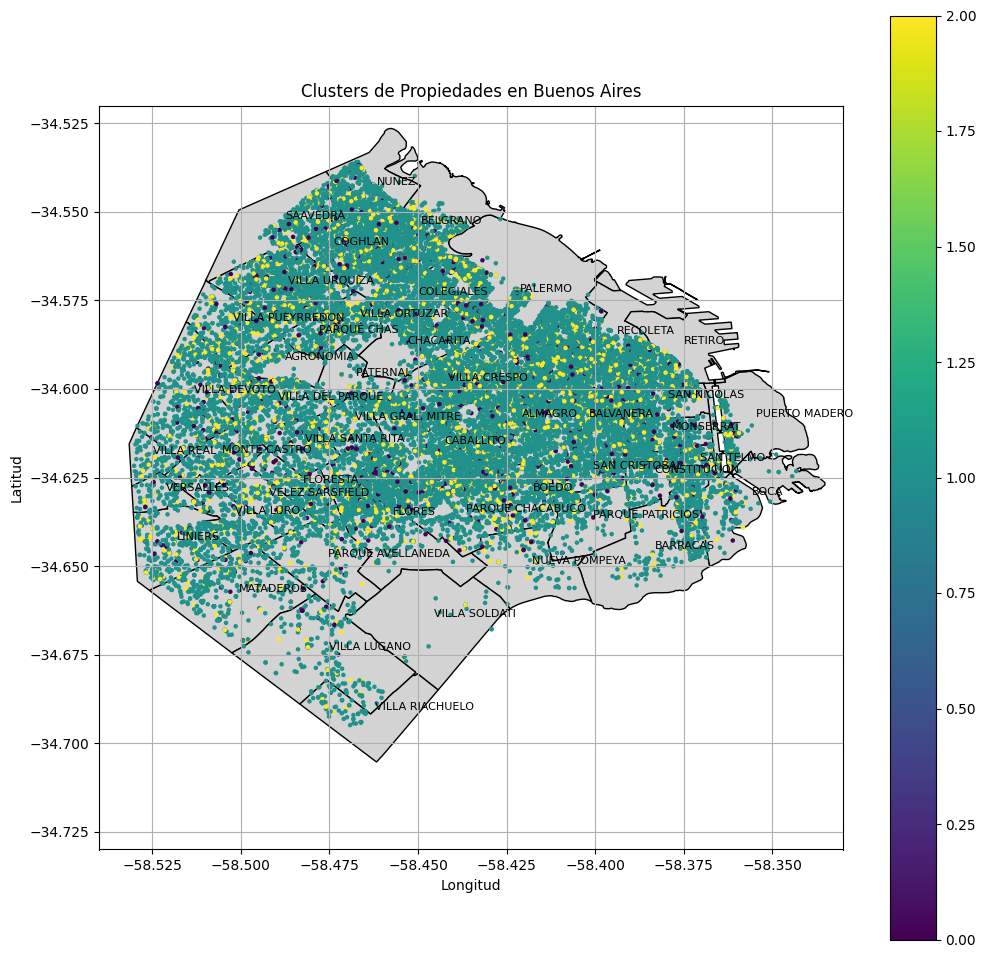

In [130]:
geometry = [Point(xy) for xy in zip(zona_kmeans_concat_df_tres['longitud'], zona_kmeans_concat_df_tres['latitud'])]

gdf_clusters = gpd.GeoDataFrame(zona_kmeans_concat_df_tres, geometry=geometry)

url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)

gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]

fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')

gdf_clusters.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, legend=True)

for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
ax.grid(True)

plt.show()

#Clasificación

En esta sección vamos a otorgarle a cada propiedad, un tipo de precio; bajo, medio, alto. Vamos a intentar predecir dicho parámetro estudiando primero, el precio por metro cuadrado.


In [134]:
zona_df = df_deptos.copy()

#Creamos la columna pxm2 dividiendo el precio de cada propiedad por su superficie total. Nos toca ahora hacer las distintas asignaciones
zona_df["pxm2"] = [p / m for p, m in zip(zona_df["property_price"], zona_df["property_surface_total"])]
#zona_df

##Gráficos.

Ahora, vamos a graficar la distribución del precio por metro cuadrado en general y por tipo de propiedad.

[Text(0.5, 1.0, 'Distribución de precio por metro cuadrado'),
 Text(0.5, 0, 'Precio por metro cuadrado (USD)'),
 Text(0, 0.5, 'Cantidad publicaciones')]

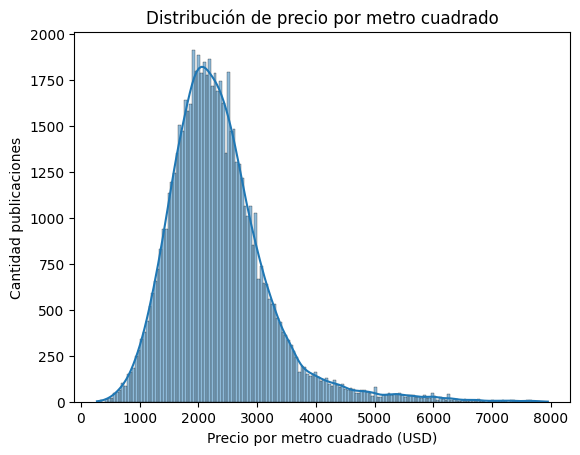

In [141]:
sns.histplot(data=zona_df["pxm2"], kde=True, alpha = 0.5).set(title="Distribución de precio por metro cuadrado",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")

Ahora, vamos a ver cómo cambia según el tipo de propiedad:


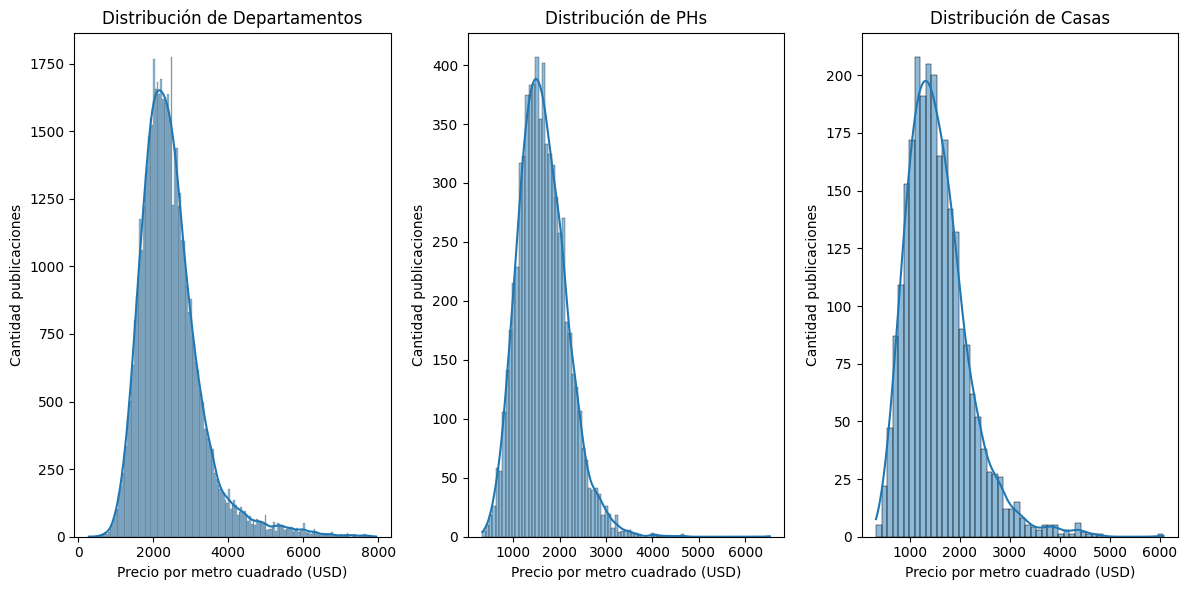

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(data=zona_df[(zona_df["property_type"]) == "Departamento"]["pxm2"], kde=True, alpha = 0.5, ax=axes[0]).set(title="Distribución de Departamentos",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
sns.histplot(data=zona_df[(zona_df["property_type"]) == "PH"]["pxm2"], kde=True, alpha = 0.5, ax=axes[1]).set(title="Distribución de PHs",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
sns.histplot(data=zona_df[(zona_df["property_type"]) == "Casa"]["pxm2"], kde=True, alpha = 0.5, ax=axes[2]).set(title="Distribución de Casas",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
plt.tight_layout()
plt.show()

## Variable *tipo_precio*

Vamos a dividir nuestro dataset y asignar a cada división, una etiqueta según el precio publicado. Las etiquetas serán Bajo, Medio, Alto. En primera instancia será una división equitativa, luego serán 25%, 50% y 25% y para lo último haremos ese mismo análisis discriminando por tipo de propiedad.

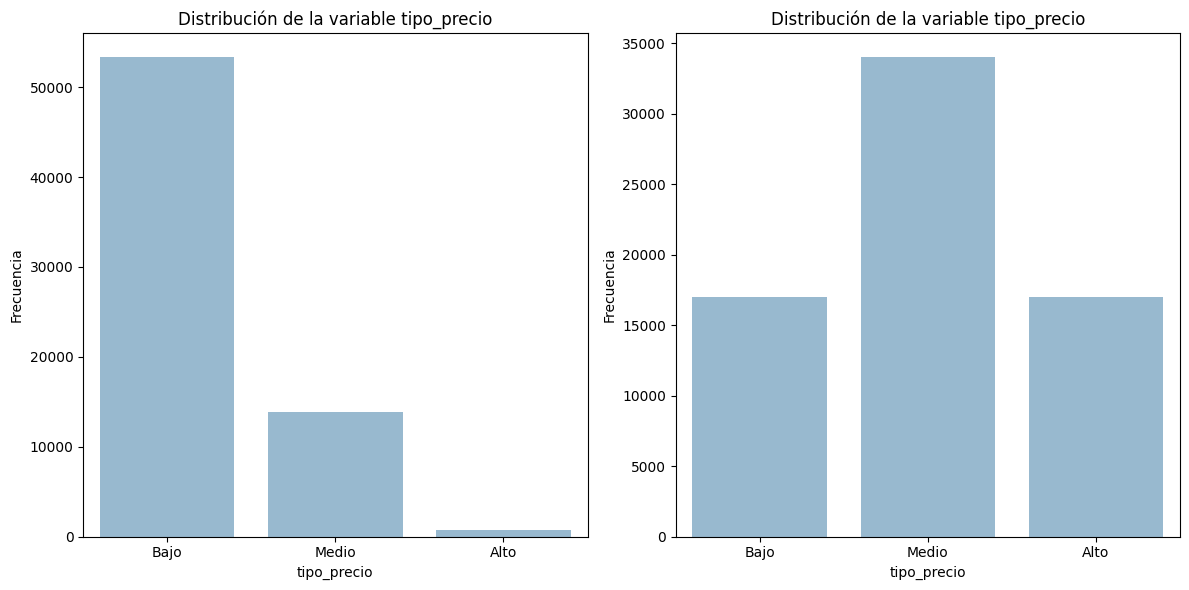

In [137]:
quantiles = [0, 0.25, 0.75, 1]
labels_nombres = ['Bajo', 'Medio', 'Alto']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

zona_df['tipo_precio'] = pd.cut(zona_df['pxm2'], bins=3, labels=labels_nombres) #divide en 3 la variable pxm2
#zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=3, labels=labels) #divide en 3 la frecuencia
df_agrupado_Tprecio1 = zona_df.groupby(["tipo_precio"]).count()

zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels_nombres)
df_agrupado_Tprecio2 = zona_df.groupby(["tipo_precio"]).count()

eje_x1 = df_agrupado_Tprecio1["pxm2"].tolist()
eje_y1 = df_agrupado_Tprecio1.index.tolist()
eje_x2 = df_agrupado_Tprecio2["pxm2"].tolist()
eje_y2 = df_agrupado_Tprecio2.index.tolist()

#cambio x por y para hacer el gráfico vertical

sns.barplot(y=eje_x1, x=eje_y1, data=df_agrupado_Tprecio1 ,alpha=0.5, ax = axes[0]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')
sns.barplot(y=eje_x2, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5, ax = axes[1]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')

plt.tight_layout()
plt.show()

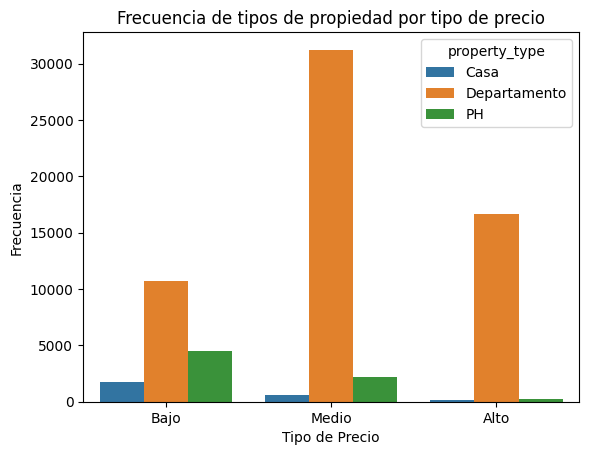

In [140]:
zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels_nombres)
df_agrupado_Tprecio = zona_df.groupby(["tipo_precio", "property_type"]).size().reset_index(name='count')

sns.barplot(data=df_agrupado_Tprecio, x='tipo_precio', y='count', hue='property_type')

plt.title('Frecuencia de tipos de propiedad por tipo de precio')
plt.xlabel('Tipo de Precio')
plt.ylabel('Frecuencia')
plt.show()


Con estas visualizaciones, se nos hace más fácil entender la distribución de los precios en las propiedades. Elegimos la última representación como la mejor opción para trabajar porque consideramos importante discriminar el tipo de propiedad.

In [ ]:
# quantiles = [0, 0.25, 0.75, 1]
# kmeans_groups = labels.copy()
# labels_nombres = ['Bajo', 'Medio', 'Alto']
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels_nombres)
# df_agrupado_Tprecio2 = zona_df.groupby(["tipo_precio"]).count()

# eje_x2 = df_agrupado_Tprecio2["pxm2"].tolist()
# eje_x1 = kmeans_groups.tolist()
# eje_y2 = df_agrupado_Tprecio2.index.tolist()

# sns.barplot(y=eje_x2, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5).\
#   set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')
# sns.barplot(y=eje_x1, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5).\
#   set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')

# plt.tight_layout()
# plt.show()

In [142]:
geometry = [Point(xy) for xy in zip(zona_df['longitud'], zona_df['latitud'])]

gdf_clusters = gpd.GeoDataFrame(zona_df, geometry=geometry)

url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)



<ipython-input-143-495896f43842>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):


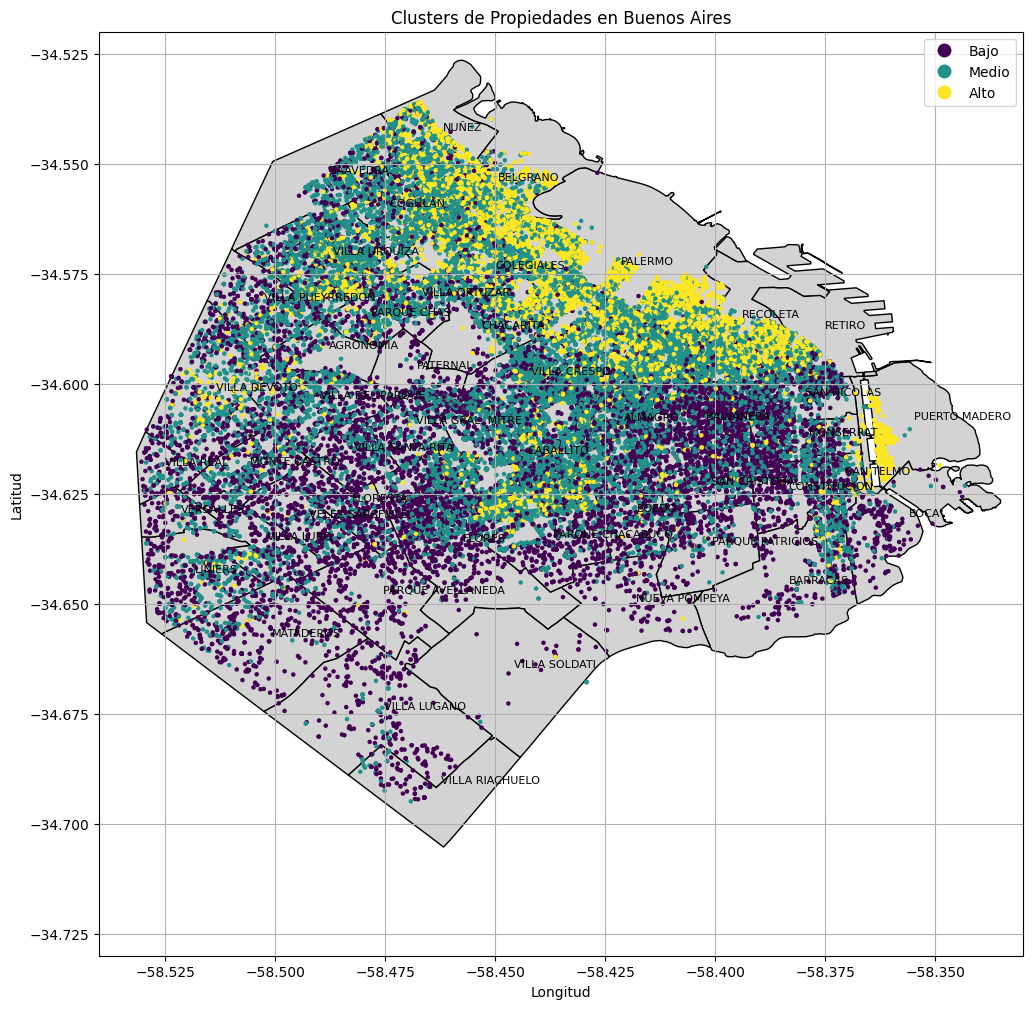

In [143]:
gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]

fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')

gdf_clusters.plot(ax=ax, column='tipo_precio', cmap='viridis', markersize=5, legend=True)

for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
ax.grid(True)

plt.show()